# Data initialisation

In [28]:
%matplotlib inline 

In [29]:
from random import randint

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from load_data import get_training_data, test_data_generator, get_validation_data, data_generator, get_test_data

In [30]:
training_data = get_training_data()
test_data = get_test_data()
validation_data = get_validation_data()

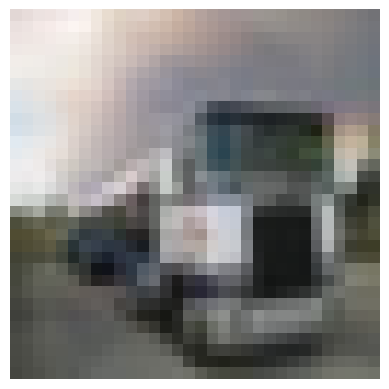

In [31]:
random_index = randint(0, len(training_data["data"]) - 1)
img = training_data["data"][random_index]

# Separate the color channels
red = img[0:1024].reshape((32, 32))
green = img[1024:2048].reshape((32, 32))
blue = img[2048:3072].reshape((32, 32))

# Stack channels along the third dimension
img_rgb = np.stack((red, green, blue), axis=2)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [32]:
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [33]:
# Define the number of classes and image size
num_classes = 10
image_size = 32

# Functions to run models

In [34]:
def run_mobilenetv3(learning_rate, train_generator, steps_per_epoch, num_epochs, validation_generator, validation_steps, batch_size):
    from mobilenetv3 import compile_mobilenet_v3_model

    mobilenet_v3_model = compile_mobilenet_v3_model(
        image_size, image_size, num_classes, learning_rate
    )

    model = mobilenet_v3_model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
    )

    plt.figure(figsize=(10, 10))
    plt.title(f'Training Loss for MobileNetV3 learning_rate={learning_rate} batch_size={batch_size}')
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    plt.legend(loc="lower right")
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.title(f'Training Loss for MobileNetV3 learning_rate={learning_rate} batch_size={batch_size}')
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="lower right")
    plt.show()

    test_generator = test_data_generator(
        test_data["data"], test_data["labels"], image_size, image_size, batch_size=batch_size
    )
    test_loss, test_acc = model.evaluate(test_generator, verbose=2)
    print(f"Test accuracy: {test_acc}")
    print(f"Test loss: {test_loss}")

In [35]:
def run_alexnet(learning_rate, train_generator, steps_per_epoch, num_epochs, validation_generator, validation_steps, batch_size):
    from alexnet import compile_alexnet_model

    alexnet_model = compile_alexnet_model(
        image_size, image_size, num_classes, learning_rate
    )

    model = alexnet_model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
    )

    plt.figure(figsize=(10, 10))
    plt.title(f'Training Loss for AlexNet learning_rate={learning_rate} batch_size={batch_size}')
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    plt.legend(loc="lower right")
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.title(f'Training Loss for AlexNet learning_rate={learning_rate} batch_size={batch_size}')
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="lower right")
    plt.show()

    test_generator = test_data_generator(
        test_data["data"], test_data["labels"], image_size, image_size, batch_size=batch_size
    )
    test_loss, test_acc = model.evaluate(test_generator, verbose=2)
    print(f"Test accuracy: {test_acc}")
    print(f"Test loss: {test_loss}")

In [36]:
def run_resnet18(learning_rate, train_generator, steps_per_epoch, num_epochs, validation_generator, validation_steps, batch_size):
    from resnet18 import compile_resnet_model

    resnet_model = compile_resnet_model(num_classes, learning_rate)

    model = resnet_model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
    )

    plt.figure(figsize=(10, 10))
    plt.title(f'Training Loss for ResNet18 learning_rate={learning_rate} batch_size={batch_size}')
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    plt.legend(loc="lower right")
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.title(f'Training Loss for ResNet18 learning_rate={learning_rate} batch_size={batch_size}')
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="lower right")
    plt.show()

    test_generator = test_data_generator(
        test_data["data"], test_data["labels"], image_size, image_size, batch_size=batch_size
    )
    test_loss, test_acc = model.evaluate(test_generator, verbose=2)
    print(f"Test accuracy: {test_acc}")
    print(f"Test loss: {test_loss}")

# Batch size tests

## Batch size = 512

In [37]:
batch_size = 512
train_generator = data_generator(
    training_data["data"], training_data["labels"], image_size, image_size, batch_size=batch_size
)
validation_generator = data_generator(
    validation_data["data"],
    validation_data["labels"],
    image_size,
    image_size,
    batch_size=batch_size,
)
# Fit the model using the generator
steps_per_epoch = len(training_data["data"]) // batch_size
validation_steps = len(validation_data["data"]) // batch_size # Because of https://developers.google.com/machine-learning/glossary/#epoch
num_epochs = 10
learning_rate = 0.001

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 101s 860ms/step - accuracy: 0.2030 - loss: 2.2449 - val_accuracy: 0.0952 - val_loss: 2.3067
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 78s 808ms/step - accuracy: 0.3844 - loss: 1.6599 - val_accuracy: 0.0949 - val_loss: 2.3093
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 60s 781ms/step - accuracy: 0.4675 - loss: 1.4450 - val_accuracy: 0.0959 - val_loss: 2.3121
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 803ms/step - accuracy: 0.5289 - loss: 1.3009 - val_accuracy: 0.0956 - val_loss: 2.3136
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 53s 684ms/step - accuracy: 0.5632 - loss: 1.1956 - val_accuracy: 0.1022 - val_loss: 2.3178
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 845ms/step - accuracy: 0.5935 - loss: 1.1144 - val_accuracy: 0.0994 - val_loss: 2.3153
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 792ms/step - accuracy: 0.6041 - loss: 1.0981 - val_accuracy: 0.0948 - val_loss: 2.3210
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 775ms/step - accuracy: 0.6564 - loss: 0.9691 - val_acc

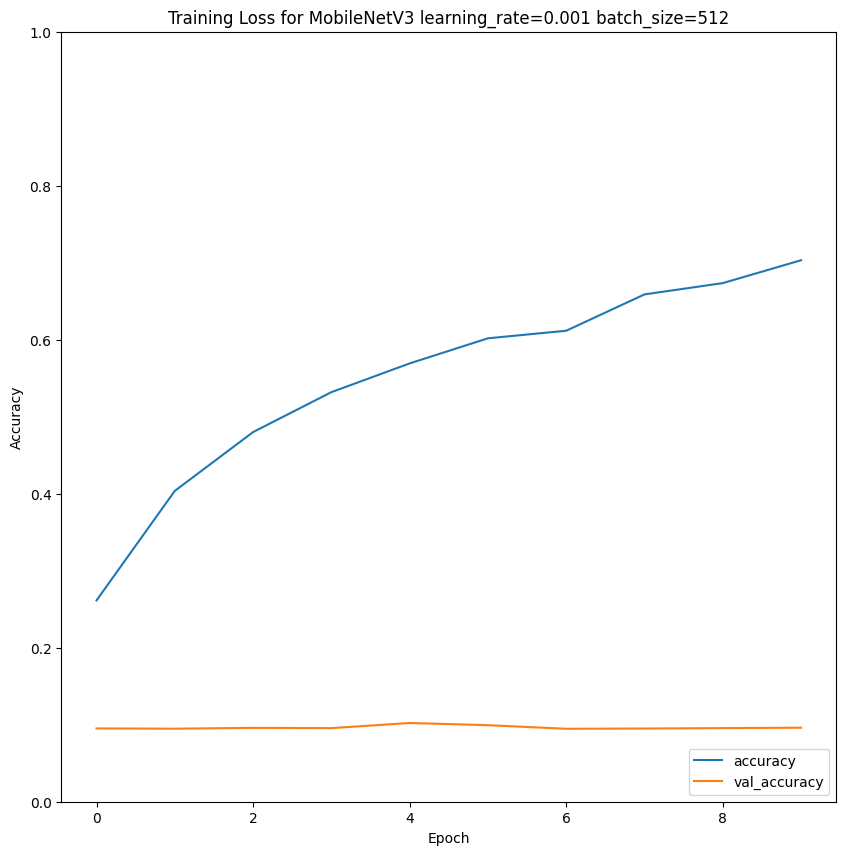

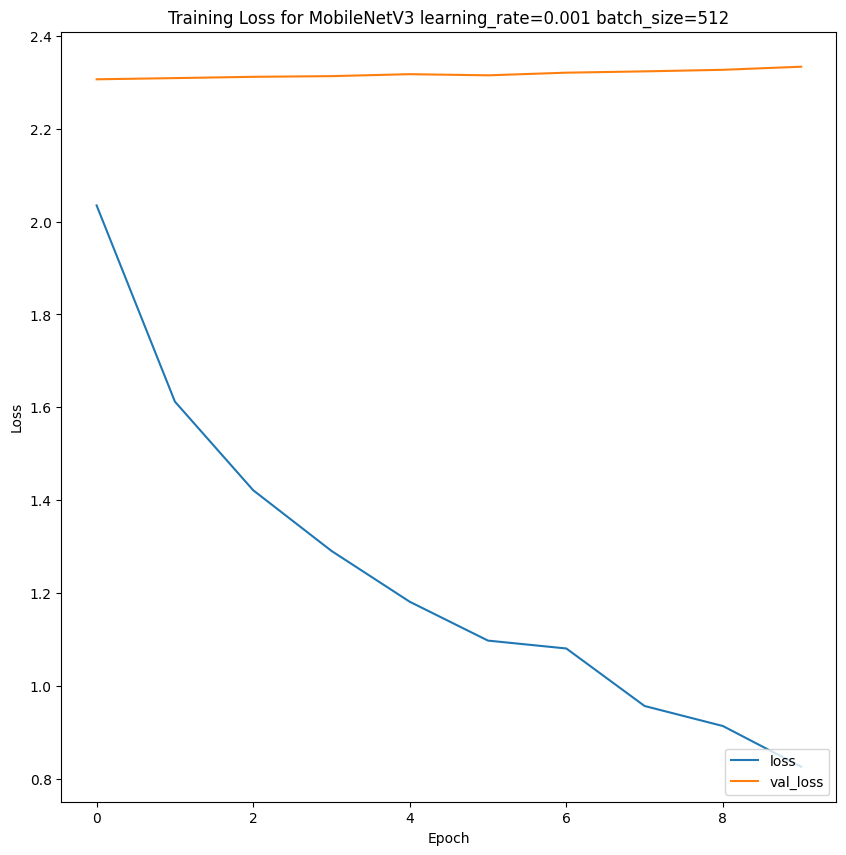

20/20 - 12s - 609ms/step - accuracy: 0.1000 - loss: 2.3300
Test accuracy: 0.10000000149011612
Test loss: 2.3300445079803467


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [38]:
run_mobilenetv3(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

/mnt/c/Users/chris/dev/repos/COMP-SCI-7318-Deep-Learning-Fundametals/Assignment2/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/mnt/c/Users/chris/dev/repos/COMP-SCI-7318-Deep-Learning-Fundametals/Assignment2/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 71s 844ms/step - accuracy: 0.2238 - loss: 2.9716 - val_accuracy: 0.3001 - val_loss: 1.8993
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 63s 813ms/step - accuracy: 0.4476 - loss: 1.5085 - val_accuracy: 0.4599 - val_loss: 1.4698
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 60s 782ms/step - accuracy: 0.5186 - loss: 1.3224 - val_accuracy: 0.5355 - val_loss: 1.3159
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 53s 681ms/step - accuracy: 0.5672 - loss: 1.2109 - val_accuracy: 0.5778 - val_loss: 1.2067
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 54s 702ms/step - accuracy: 0.6230 - loss: 1.0656 - val_accuracy: 0.6148 - val_loss: 1.1117
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 797ms/step - accuracy: 0.6681 - loss: 0.9414 - val_accuracy: 0.6344 - val_loss: 1.0893
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 59s 751ms/step - accuracy: 0.7056 - loss: 0.8442 - val_accuracy: 0.6400 - val_loss: 1.0676
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 56s 717ms/step - accuracy: 0.7424 - loss: 0.7382 - val_accu

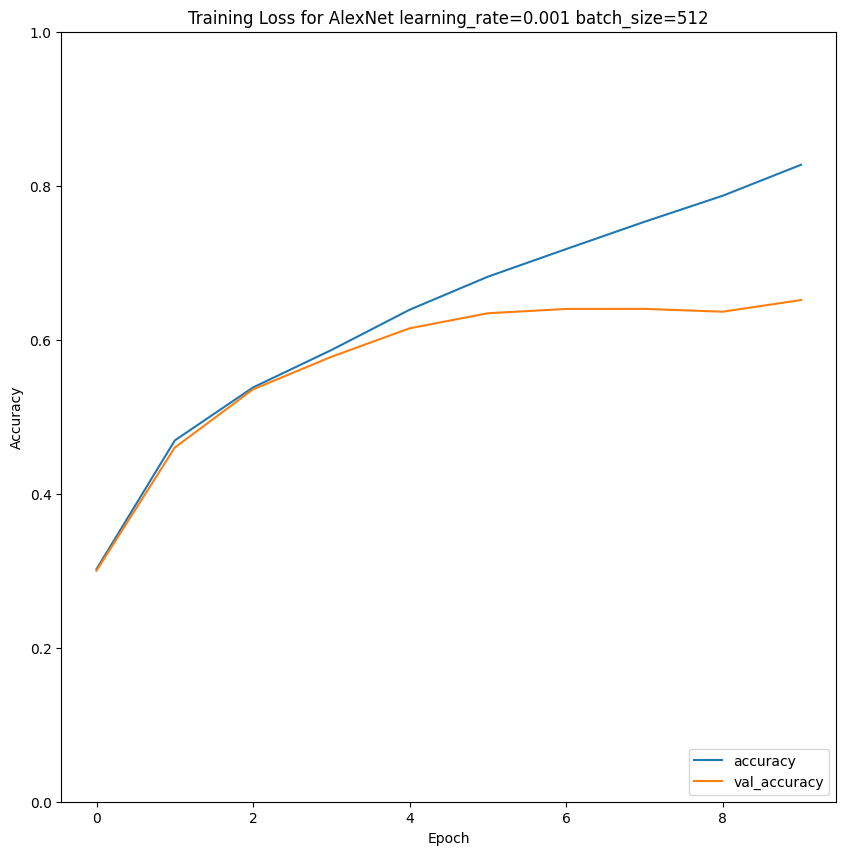

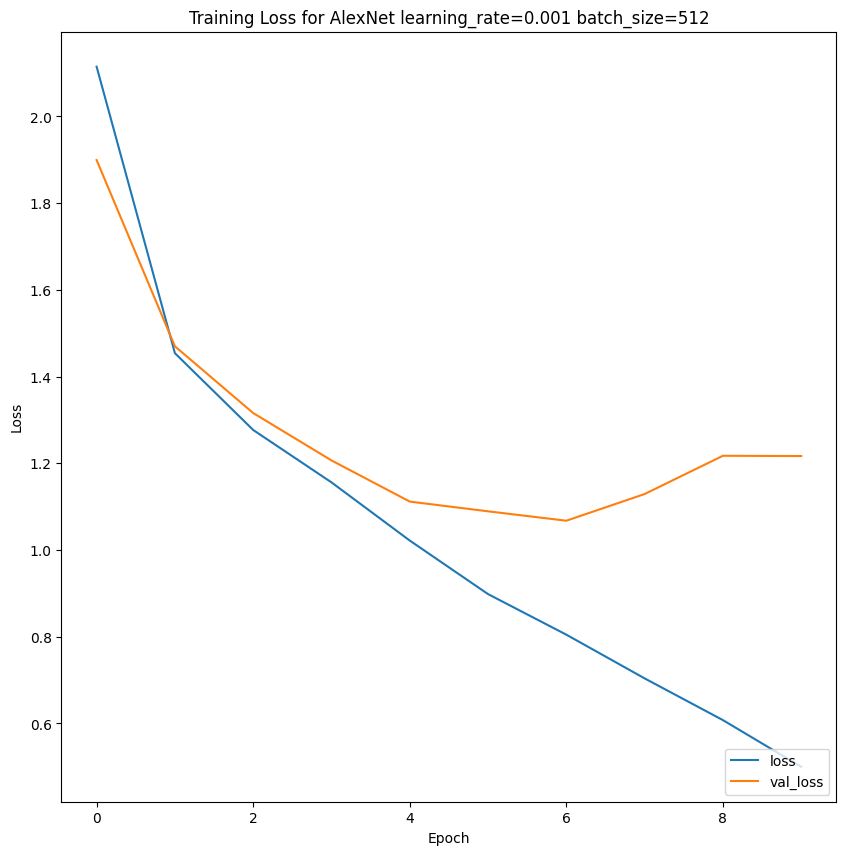

20/20 - 12s - 615ms/step - accuracy: 0.6465 - loss: 1.2550
Test accuracy: 0.6464999914169312
Test loss: 1.2550461292266846


2024-11-09 12:46:01.769700: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 12:46:01.769847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [39]:
run_alexnet(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 70s 856ms/step - accuracy: 0.1974 - loss: 10.6862 - val_accuracy: 0.3189 - val_loss: 1.9452
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 856ms/step - accuracy: 0.3517 - loss: 1.8849 - val_accuracy: 0.3992 - val_loss: 1.7409
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 831ms/step - accuracy: 0.3982 - loss: 1.7455 - val_accuracy: 0.4134 - val_loss: 1.7573
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 54s 692ms/step - accuracy: 0.4341 - loss: 1.6558 - val_accuracy: 0.4685 - val_loss: 1.5160
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 51s 663ms/step - accuracy: 0.4534 - loss: 1.5825 - val_accuracy: 0.4410 - val_loss: 1.7062
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 59s 763ms/step - accuracy: 0.4664 - loss: 1.5868 - val_accuracy: 0.4824 - val_loss: 1.4778
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 57s 728ms/step - accuracy: 0.4985 - loss: 1.4425 - val_accuracy: 0.4825 - val_loss: 1.5763
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 55s 698ms/step - accuracy: 0.4992 - loss: 1.4619 - val_acc

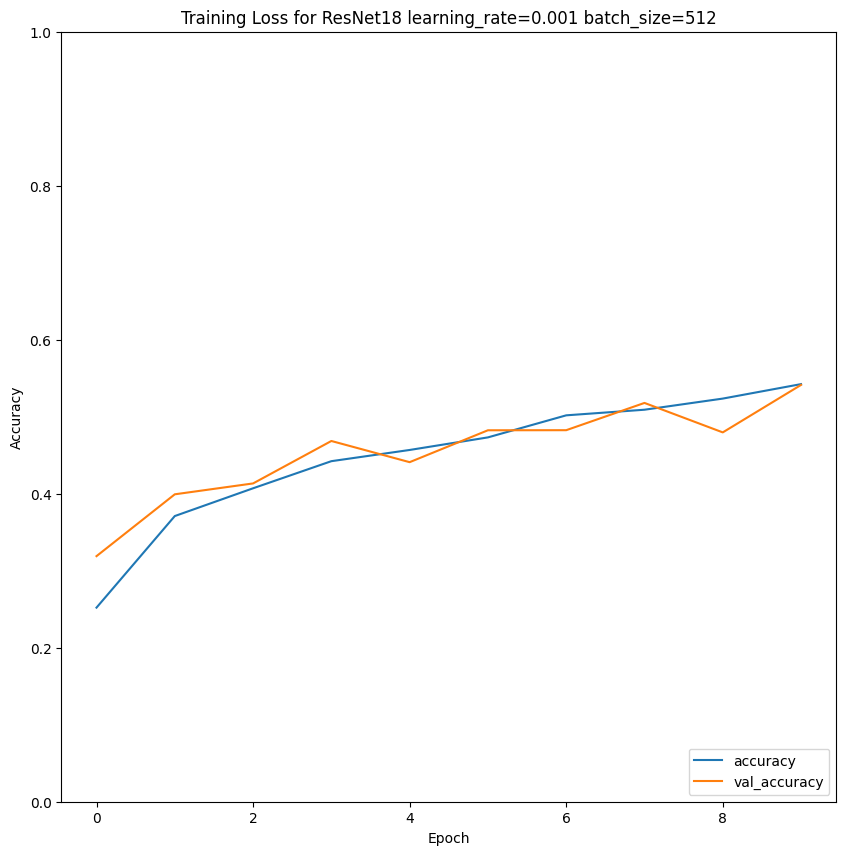

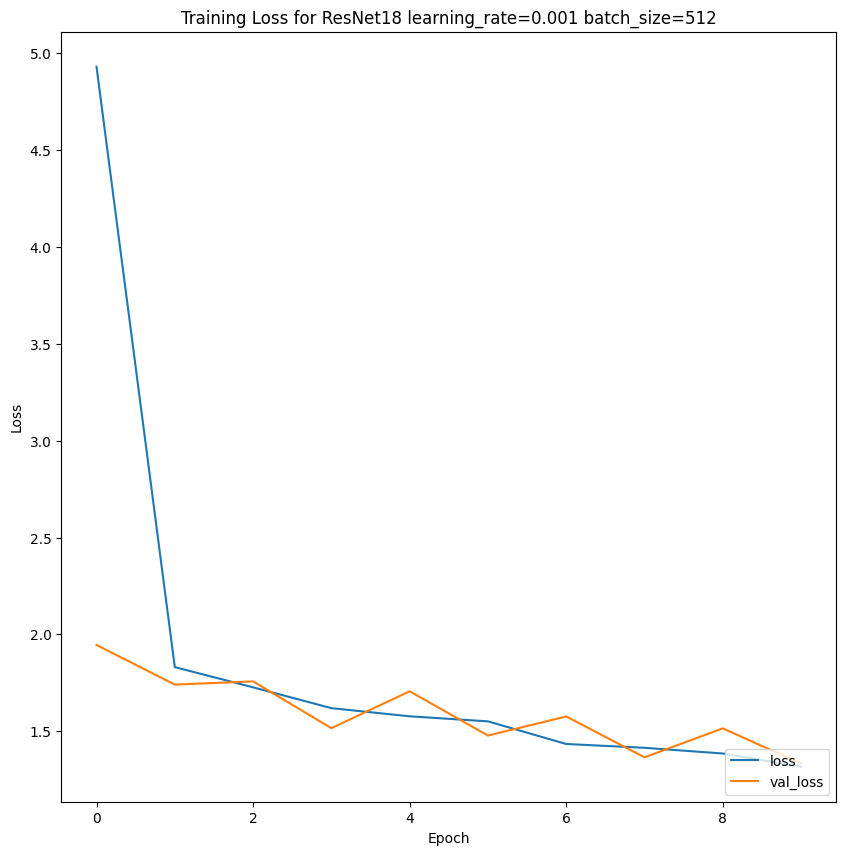

20/20 - 12s - 609ms/step - accuracy: 0.5339 - loss: 1.3411
Test accuracy: 0.5339000225067139
Test loss: 1.3410601615905762


2024-11-09 12:56:02.893204: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 12:56:02.893296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [40]:
run_resnet18(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

## Batch size = 128

In [41]:
batch_size = 128
train_generator = data_generator(
    training_data["data"], training_data["labels"], image_size, image_size, batch_size=batch_size
)
validation_generator = data_generator(
    validation_data["data"],
    validation_data["labels"],
    image_size,
    image_size,
    batch_size=batch_size,
)
# Fit the model using the generator
steps_per_epoch = len(training_data["data"]) // batch_size
validation_steps = len(validation_data["data"]) // batch_size # Because of https://developers.google.com/machine-learning/glossary/#epoch
num_epochs = 10
learning_rate = 0.001

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 102s 234ms/step - accuracy: 0.2664 - loss: 2.0443 - val_accuracy: 0.0953 - val_loss: 2.3096
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 86s 235ms/step - accuracy: 0.4573 - loss: 1.5109 - val_accuracy: 0.0947 - val_loss: 2.3174
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - accuracy: 0.5196 - loss: 1.3523 - val_accuracy: 0.0960 - val_loss: 2.3213
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 73s 233ms/step - accuracy: 0.5603 - loss: 1.2278 - val_accuracy: 0.0950 - val_loss: 2.3291
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.6083 - loss: 1.1078 - val_accuracy: 0.0949 - val_loss: 2.3268
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 68s 217ms/step - accuracy: 0.6325 - loss: 1.0532 - val_accuracy: 0.0950 - val_loss: 2.3406
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 59s 190ms/step - accuracy: 0.6571 - loss: 0.9652 - val_accuracy: 0.0957 - val_loss: 2.3606
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 68s 217ms/step - accuracy: 0.6851 - loss: 

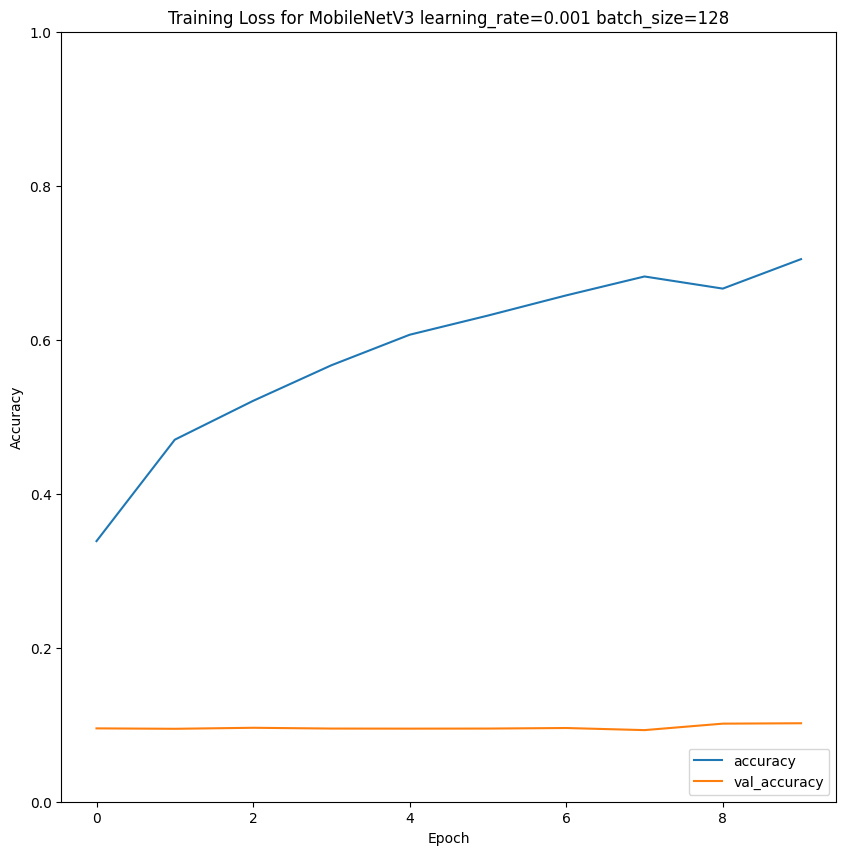

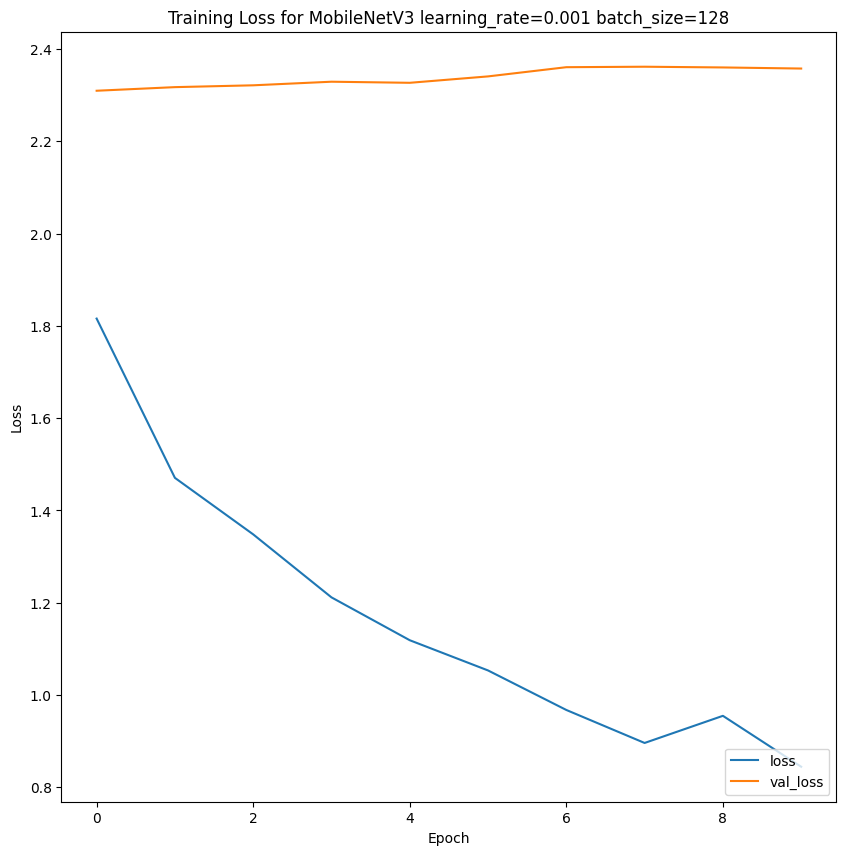

79/79 - 14s - 171ms/step - accuracy: 0.1000 - loss: 2.3598
Test accuracy: 0.10000000149011612
Test loss: 2.3598227500915527


2024-11-09 13:08:27.144952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 13:08:27.145025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [42]:
run_mobilenetv3(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 84s 254ms/step - accuracy: 0.3230 - loss: 2.1505 - val_accuracy: 0.4365 - val_loss: 1.6035
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 226ms/step - accuracy: 0.5052 - loss: 1.3642 - val_accuracy: 0.5501 - val_loss: 1.2683
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 239ms/step - accuracy: 0.5842 - loss: 1.1797 - val_accuracy: 0.6024 - val_loss: 1.1581
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 76s 245ms/step - accuracy: 0.6409 - loss: 1.0226 - val_accuracy: 0.6156 - val_loss: 1.1091
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 232ms/step - accuracy: 0.6848 - loss: 0.9000 - val_accuracy: 0.6435 - val_loss: 1.0660
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 62s 198ms/step - accuracy: 0.7309 - loss: 0.7786 - val_accuracy: 0.6500 - val_loss: 1.0997
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - accuracy: 0.7776 - loss: 0.6530 - val_accuracy: 0.6512 - val_loss: 1.0912
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 68s 217ms/step - accuracy: 0.8106 - loss: 0

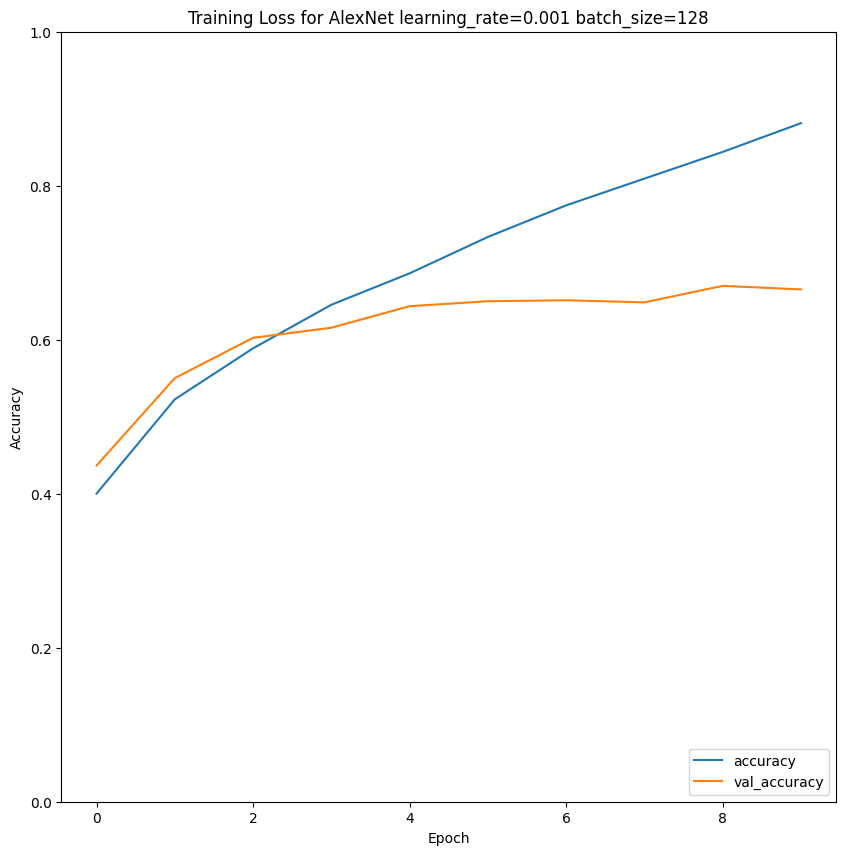

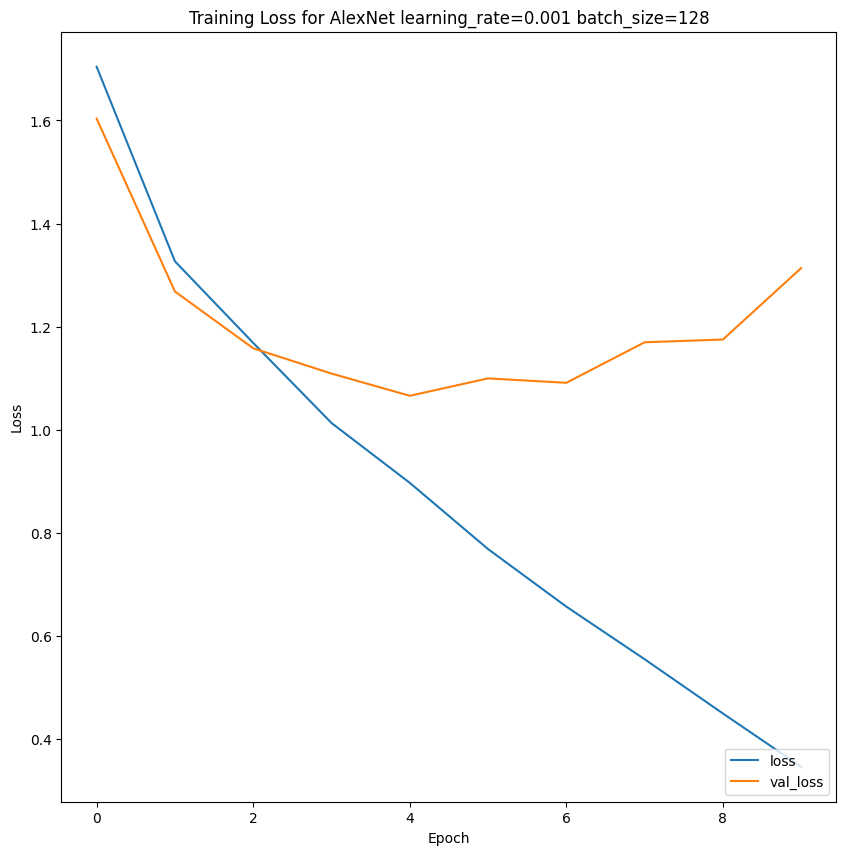

79/79 - 14s - 172ms/step - accuracy: 0.6676 - loss: 1.3374
Test accuracy: 0.6675999760627747
Test loss: 1.337386965751648


2024-11-09 13:20:35.974268: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 13:20:35.974353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [43]:
run_alexnet(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 80s 231ms/step - accuracy: 0.2585 - loss: 5.8179 - val_accuracy: 0.4122 - val_loss: 1.7580
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 73s 234ms/step - accuracy: 0.4145 - loss: 1.8712 - val_accuracy: 0.4503 - val_loss: 1.6295
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 76s 243ms/step - accuracy: 0.4591 - loss: 1.6852 - val_accuracy: 0.5170 - val_loss: 1.4558
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 77s 246ms/step - accuracy: 0.5070 - loss: 1.4872 - val_accuracy: 0.5332 - val_loss: 1.3666
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 226ms/step - accuracy: 0.5450 - loss: 1.3497 - val_accuracy: 0.5778 - val_loss: 1.2331
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 64s 205ms/step - accuracy: 0.5648 - loss: 1.2776 - val_accuracy: 0.5630 - val_loss: 1.2624
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 61s 195ms/step - accuracy: 0.5890 - loss: 1.2076 - val_accuracy: 0.5814 - val_loss: 1.2236
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 67s 216ms/step - accuracy: 0.6114 - loss: 1

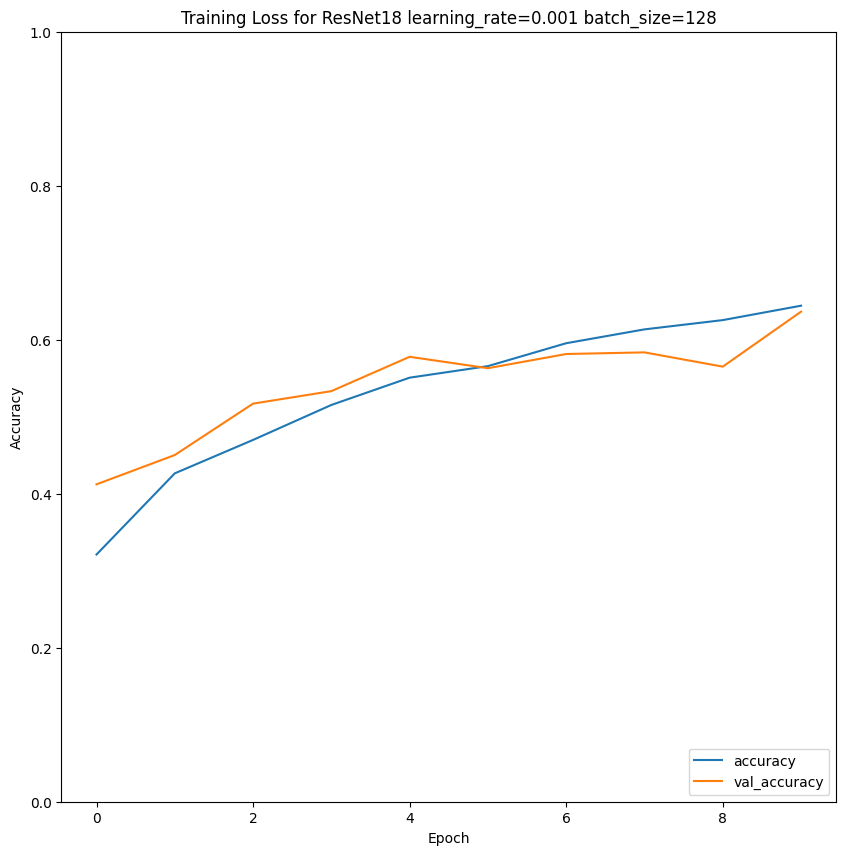

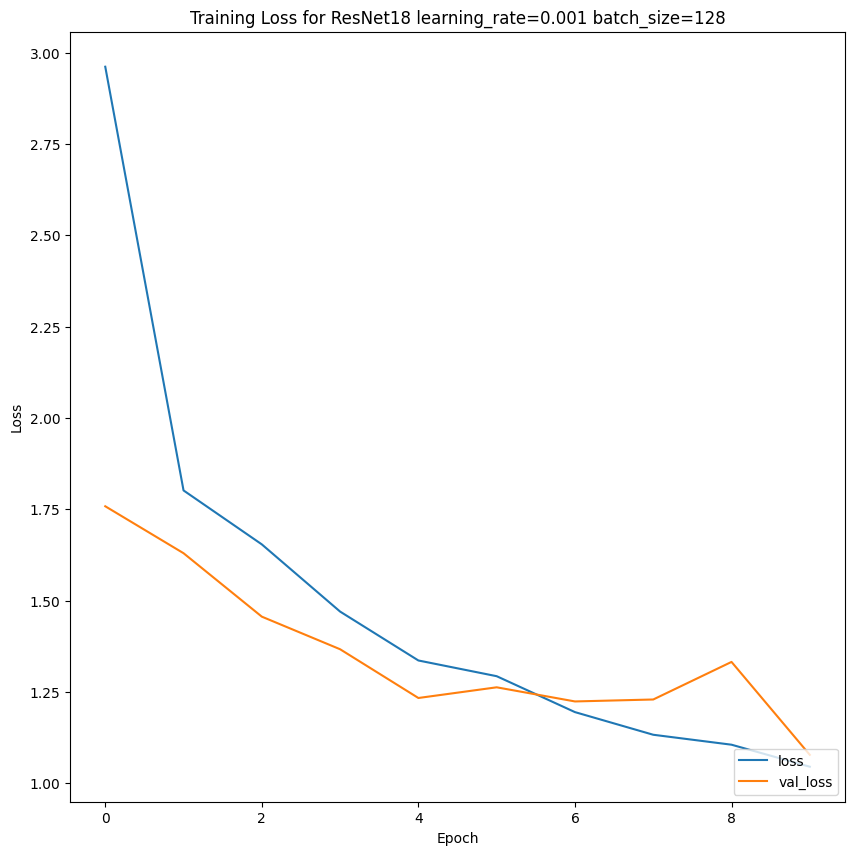

79/79 - 13s - 167ms/step - accuracy: 0.6428 - loss: 1.0590
Test accuracy: 0.642799973487854
Test loss: 1.0590200424194336


2024-11-09 13:32:29.656761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 13:32:29.656817: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [44]:
run_resnet18(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

## Batch size = 32

In [45]:
batch_size = 32
train_generator = data_generator(
    training_data["data"], training_data["labels"], image_size, image_size, batch_size=batch_size
)
validation_generator = data_generator(
    validation_data["data"],
    validation_data["labels"],
    image_size,
    image_size,
    batch_size=batch_size,
)
# Fit the model using the generator
steps_per_epoch = len(training_data["data"]) // batch_size
validation_steps = len(validation_data["data"]) // batch_size # Because of https://developers.google.com/machine-learning/glossary/#epoch
num_epochs = 10
learning_rate = 0.001

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 113s 67ms/step - accuracy: 0.2597 - loss: 2.0489 - val_accuracy: 0.0952 - val_loss: 2.3110
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.4190 - loss: 1.5833 - val_accuracy: 0.0952 - val_loss: 2.3276
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.4790 - loss: 1.4728 - val_accuracy: 0.1967 - val_loss: 2.1611
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.5043 - loss: 1.4027 - val_accuracy: 0.3649 - val_loss: 2.9249
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 69ms/step - accuracy: 0.5366 - loss: 1.3105 - val_accuracy: 0.3625 - val_loss: 4.4773
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.5475 - loss: 1.3024 - val_accuracy: 0.3710 - val_loss: 4.2593
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.6026 - loss: 1.1094 - val_accuracy: 0.5354 - val_loss: 2.0998
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - accuracy: 0.6324 

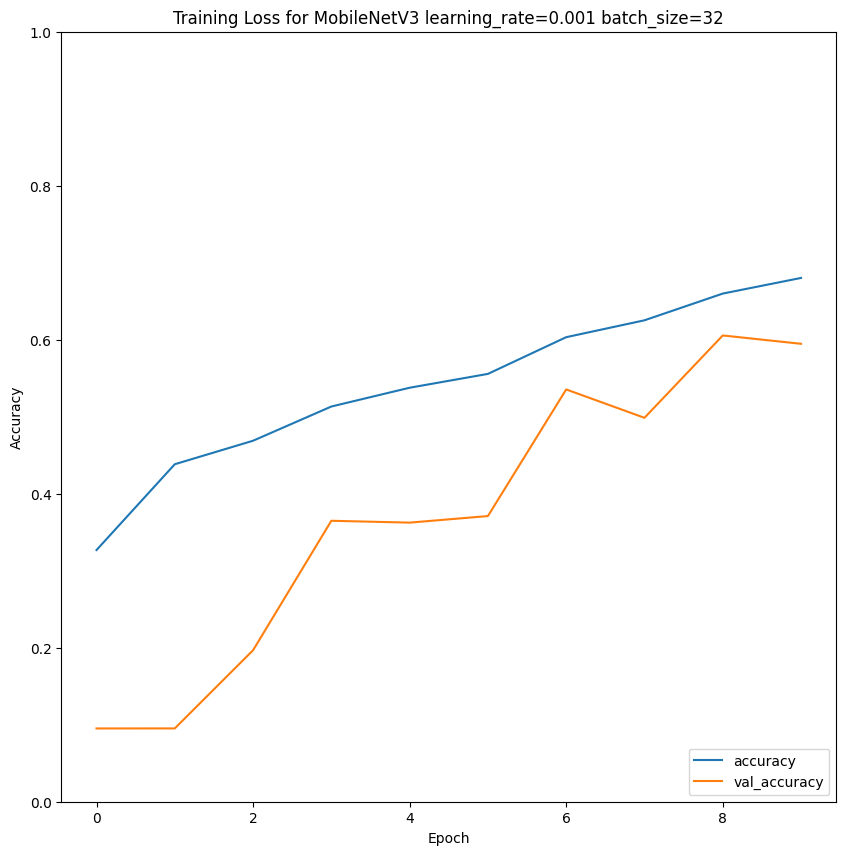

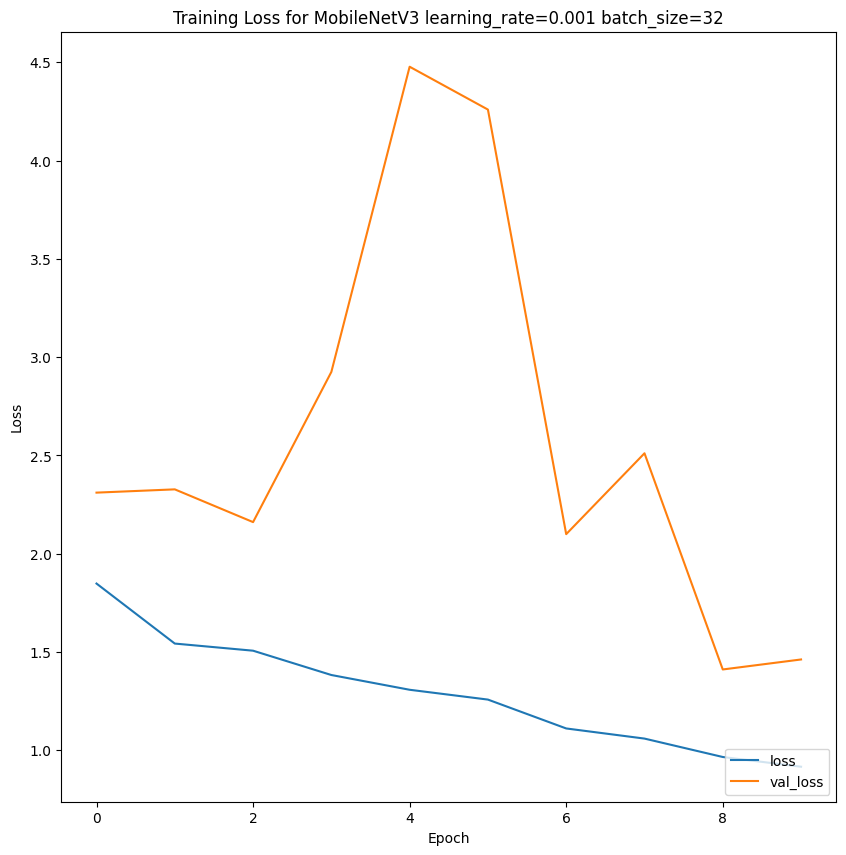

313/313 - 14s - 46ms/step - accuracy: 0.5972 - loss: 1.5180
Test accuracy: 0.5971999764442444
Test loss: 1.5180370807647705


2024-11-09 13:46:59.470732: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-09 13:46:59.470796: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 13:46:59.470824: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [46]:
run_mobilenetv3(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 70ms/step - accuracy: 0.3197 - loss: 1.9539 - val_accuracy: 0.4674 - val_loss: 1.5109
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.5024 - loss: 1.4051 - val_accuracy: 0.5518 - val_loss: 1.2753
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.5730 - loss: 1.2179 - val_accuracy: 0.5702 - val_loss: 1.2293
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.6285 - loss: 1.0790 - val_accuracy: 0.6196 - val_loss: 1.0878
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.6797 - loss: 0.9354 - val_accuracy: 0.6384 - val_loss: 1.0413
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.7273 - loss: 0.7968 - val_accuracy: 0.6577 - val_loss: 1.0608
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.7660 - loss: 0.6910 - val_accuracy: 0.6618 - val_loss: 1.1129
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.8085 -

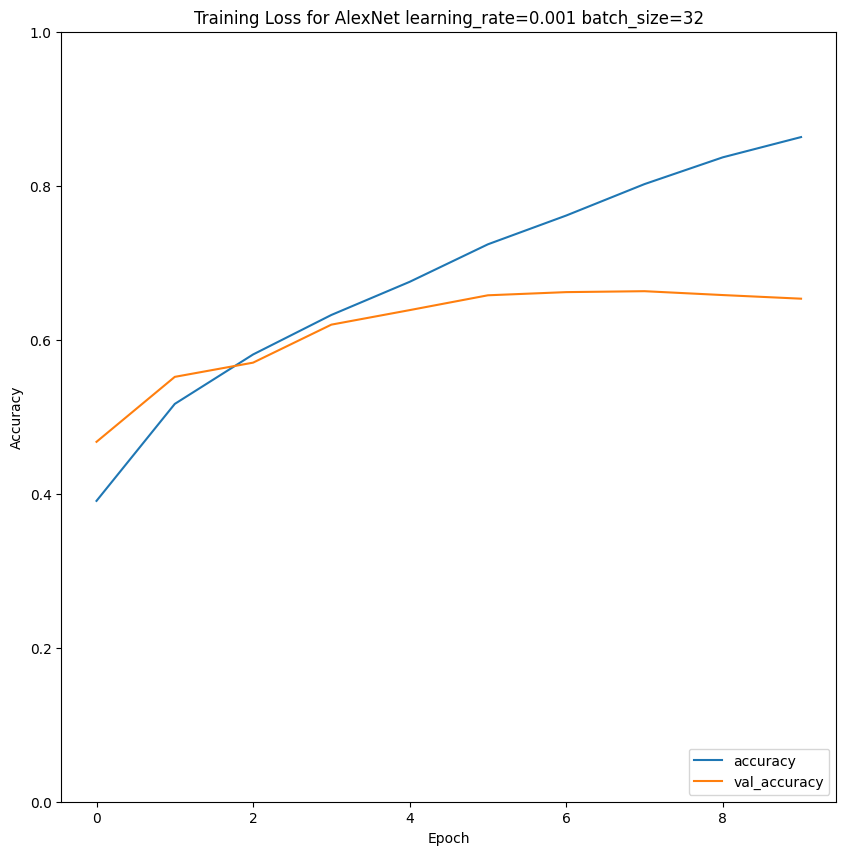

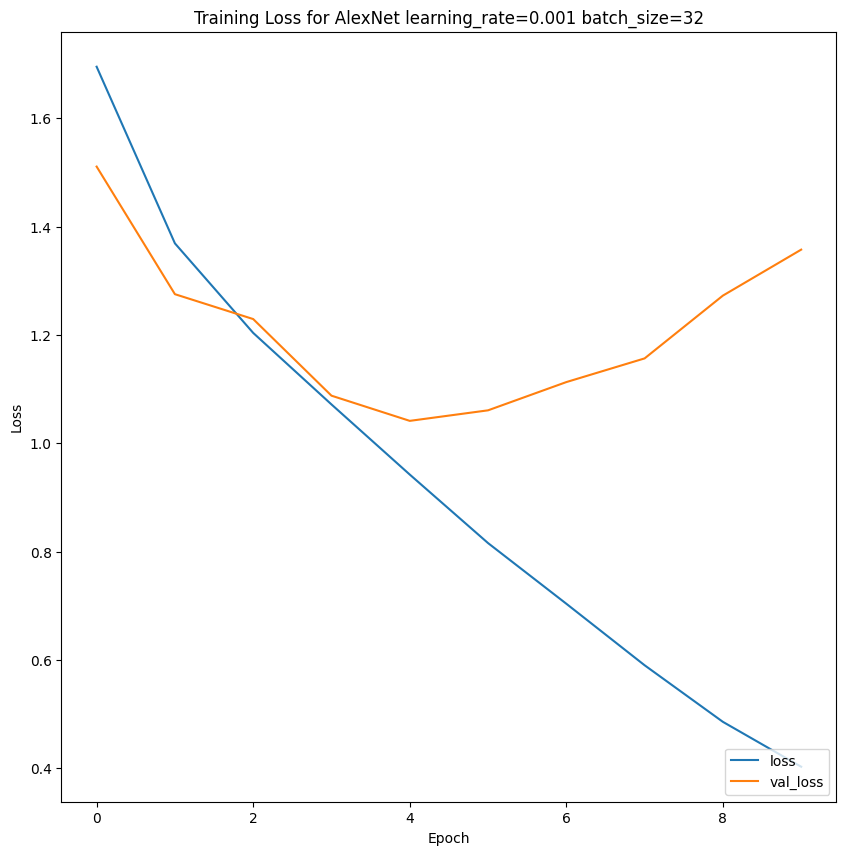

313/313 - 14s - 46ms/step - accuracy: 0.6566 - loss: 1.3510
Test accuracy: 0.6565999984741211
Test loss: 1.3510105609893799


2024-11-09 14:01:10.924283: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911
2024-11-09 14:01:10.924341: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773


In [47]:
run_alexnet(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 65ms/step - accuracy: 0.2826 - loss: 4.1936 - val_accuracy: 0.4061 - val_loss: 1.8945
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.4186 - loss: 1.8893 - val_accuracy: 0.4731 - val_loss: 1.5730
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s 62ms/step - accuracy: 0.4925 - loss: 1.5492 - val_accuracy: 0.5074 - val_loss: 1.4473
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s 62ms/step - accuracy: 0.5371 - loss: 1.3796 - val_accuracy: 0.5570 - val_loss: 1.2608
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.5764 - loss: 1.2823 - val_accuracy: 0.6232 - val_loss: 1.1744
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.6002 - loss: 1.1882 - val_accuracy: 0.6170 - val_loss: 1.1064
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 59ms/step - accuracy: 0.6396 - loss: 1.0513 - val_accuracy: 0.6776 - val_loss: 0.9639
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 59ms/step - accuracy: 0.6640 -

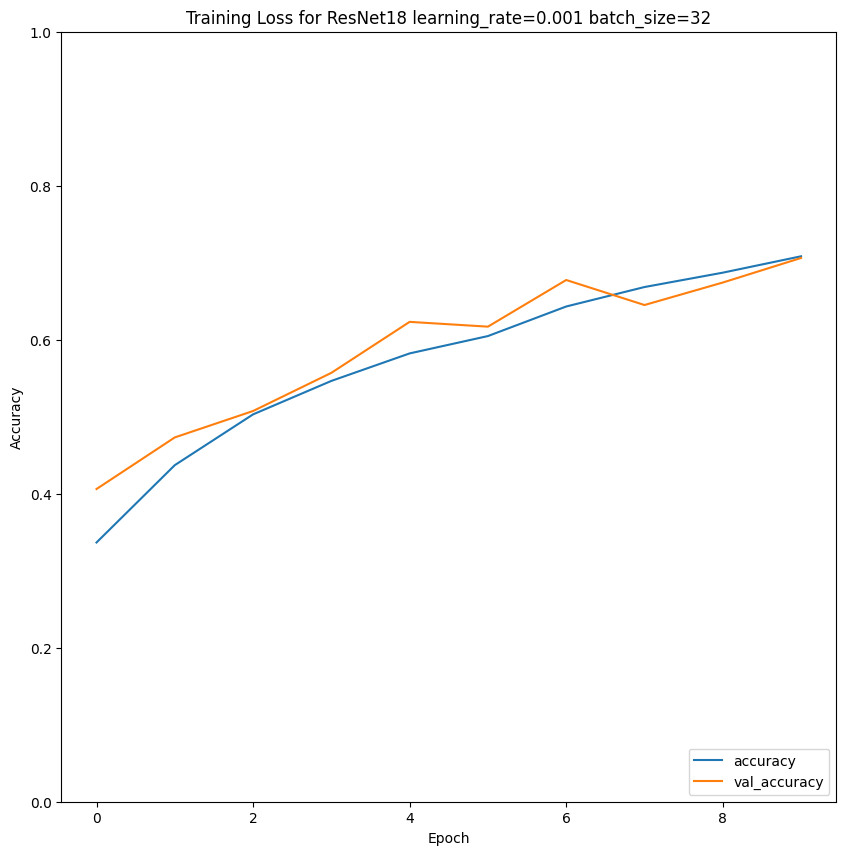

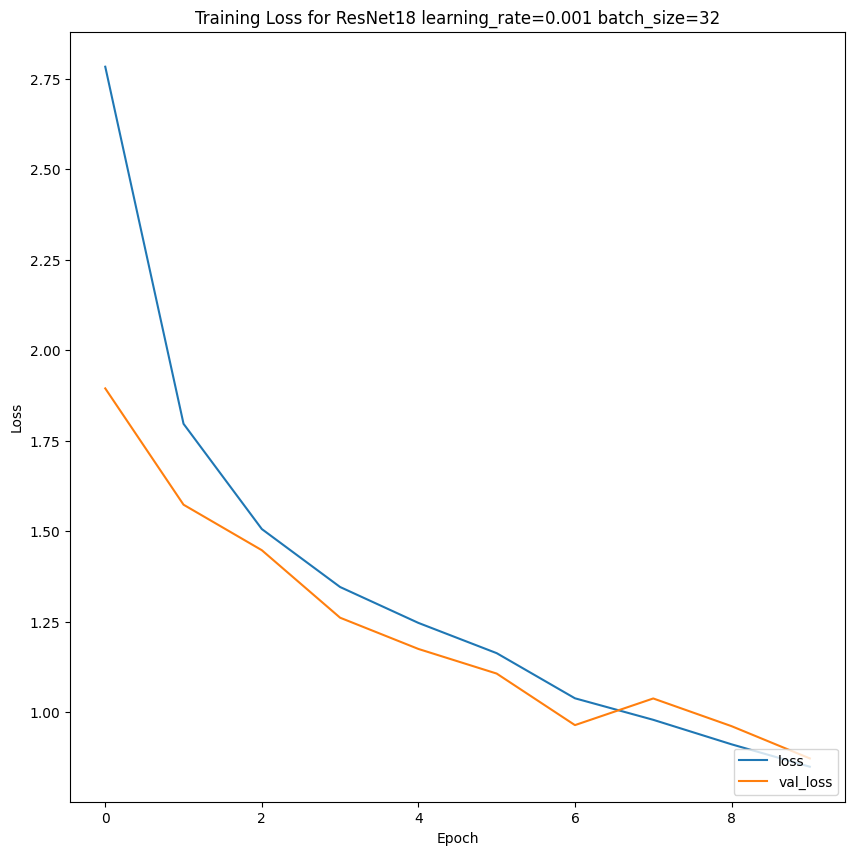

313/313 - 16s - 50ms/step - accuracy: 0.6996 - loss: 0.8950
Test accuracy: 0.6995999813079834
Test loss: 0.8949704170227051


2024-11-09 14:14:11.562566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911
2024-11-09 14:14:11.562637: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773


In [48]:
run_resnet18(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

# Learning Rate tests

## Learning rate = 0.001

In [51]:
batch_size = 32
train_generator = data_generator(
    training_data["data"], training_data["labels"], image_size, image_size, batch_size=batch_size
)
validation_generator = data_generator(
    validation_data["data"],
    validation_data["labels"],
    image_size,
    image_size,
    batch_size=batch_size,
)
# Fit the model using the generator
steps_per_epoch = len(training_data["data"]) // batch_size
validation_steps = len(validation_data["data"]) // batch_size # Because of https://developers.google.com/machine-learning/glossary/#epoch
num_epochs = 20
learning_rate = 0.001

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 73ms/step - accuracy: 0.2914 - loss: 1.9735 - val_accuracy: 0.1015 - val_loss: 2.3189
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.4488 - loss: 1.5377 - val_accuracy: 0.1018 - val_loss: 2.3159
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.5099 - loss: 1.3617 - val_accuracy: 0.1762 - val_loss: 2.1593
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.5502 - loss: 1.2748 - val_accuracy: 0.4972 - val_loss: 1.6545
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.6077 - loss: 1.1259 - val_accuracy: 0.5518 - val_loss: 1.5792
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.6459 - loss: 1.0240 - val_accuracy: 0.4246 - val_loss: 3.9639
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.6427 - loss: 1.0391 - val_accuracy: 0.5217 - val_loss: 2.1746
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.6868 

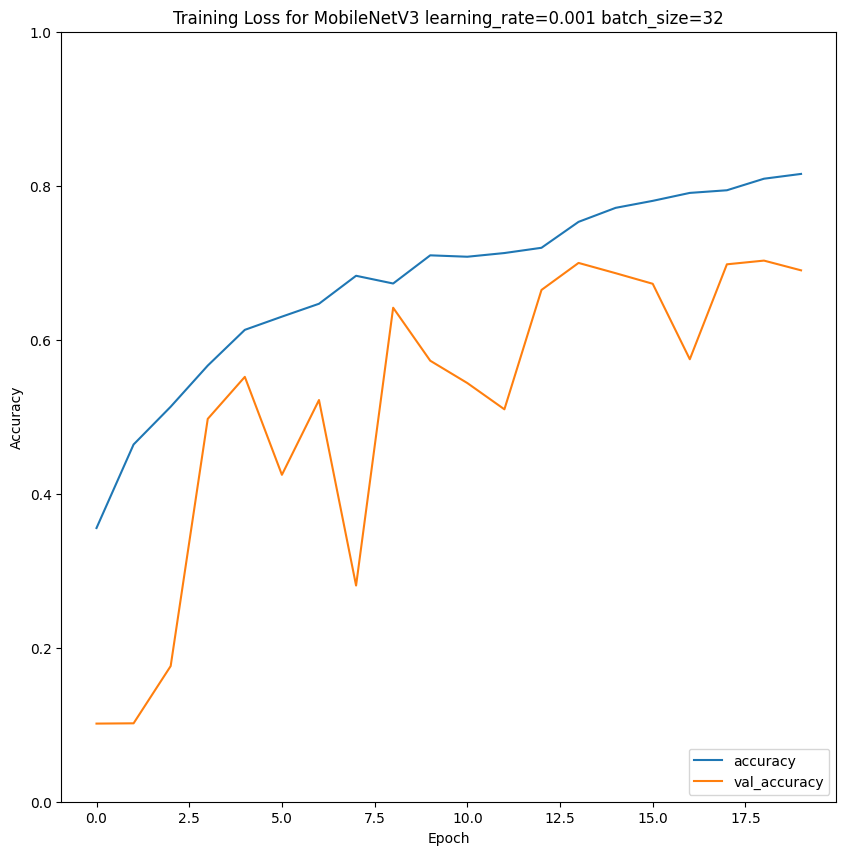

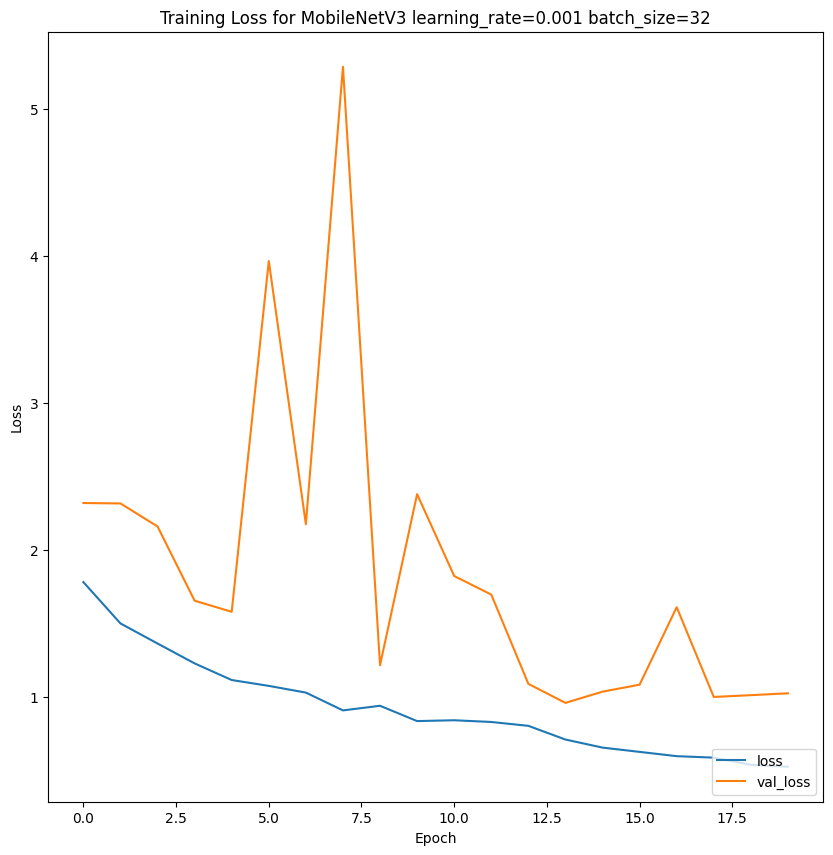

313/313 - 17s - 54ms/step - accuracy: 0.6869 - loss: 1.0381
Test accuracy: 0.6869000196456909
Test loss: 1.0380897521972656


In [52]:
run_mobilenetv3(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 72ms/step - accuracy: 0.3246 - loss: 1.9532 - val_accuracy: 0.4709 - val_loss: 1.5091
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.5022 - loss: 1.4073 - val_accuracy: 0.5393 - val_loss: 1.2897
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.5696 - loss: 1.2267 - val_accuracy: 0.5892 - val_loss: 1.1937
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.6247 - loss: 1.0768 - val_accuracy: 0.6199 - val_loss: 1.1132
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.6729 - loss: 0.9548 - val_accuracy: 0.6352 - val_loss: 1.1023
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.7195 - loss: 0.8173 - val_accuracy: 0.6499 - val_loss: 1.0812
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 68ms/step - accuracy: 0.7596 - loss: 0.7040 - val_accuracy: 0.6507 - val_loss: 1.1343
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.8008 -

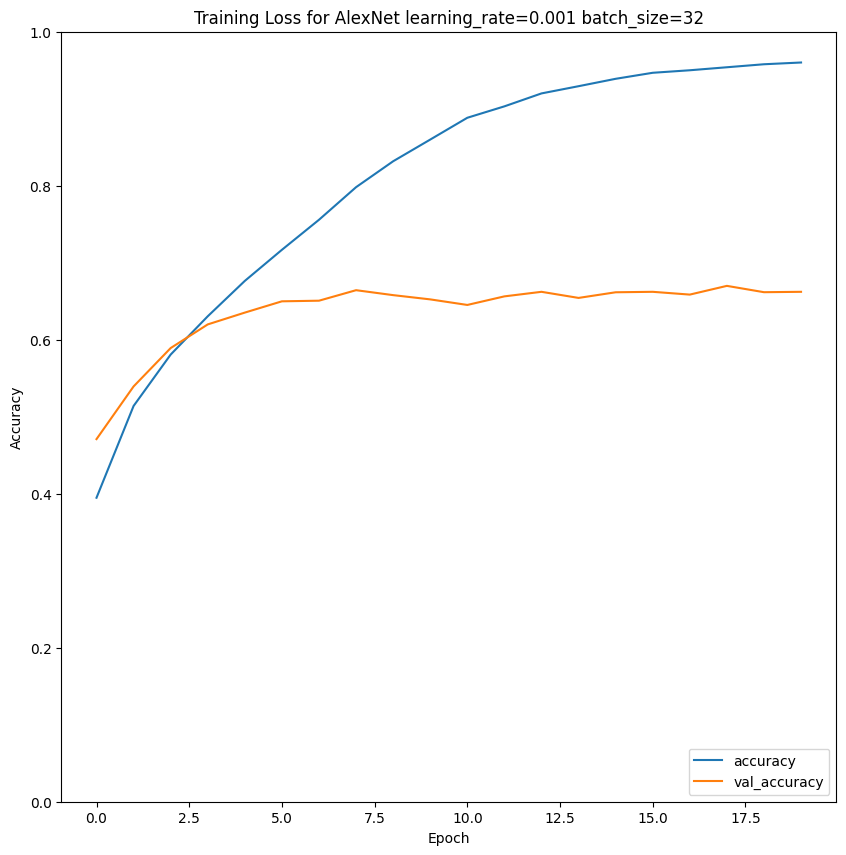

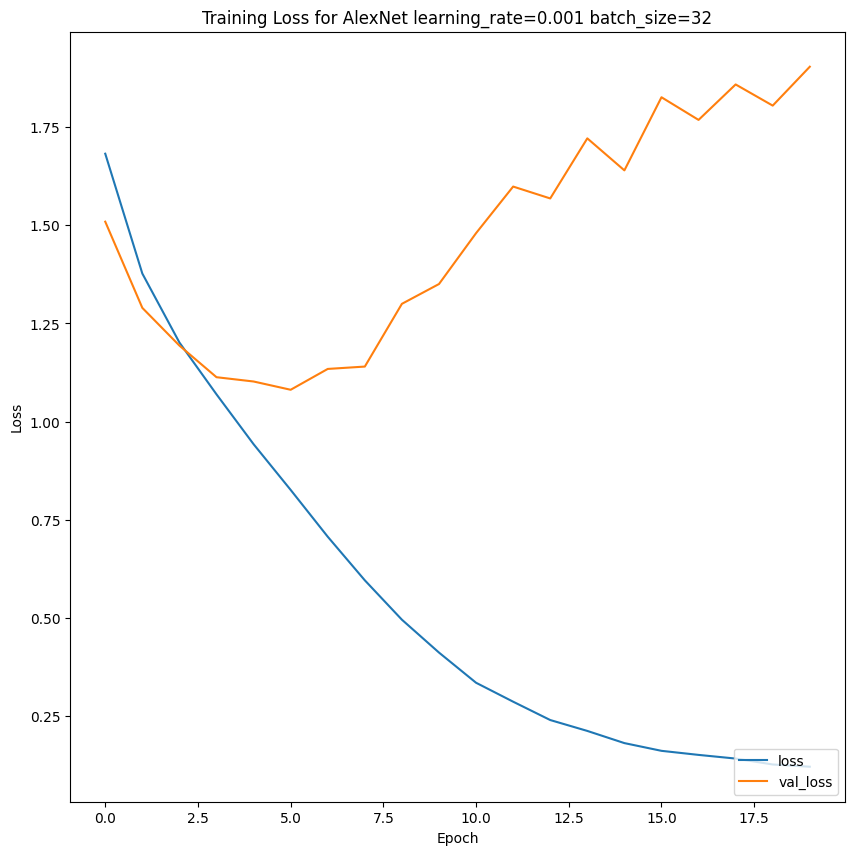

313/313 - 17s - 53ms/step - accuracy: 0.6548 - loss: 1.9217
Test accuracy: 0.6547999978065491
Test loss: 1.9217413663864136


2024-11-09 15:30:07.610174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 15:30:07.610301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [53]:
run_alexnet(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 69ms/step - accuracy: 0.2782 - loss: 4.3201 - val_accuracy: 0.3793 - val_loss: 2.6526
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.4158 - loss: 1.9416 - val_accuracy: 0.4503 - val_loss: 1.7324
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.4829 - loss: 1.5922 - val_accuracy: 0.5020 - val_loss: 1.5002
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.5318 - loss: 1.3965 - val_accuracy: 0.5673 - val_loss: 1.3395
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.5685 - loss: 1.2772 - val_accuracy: 0.5904 - val_loss: 1.2005
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.5932 - loss: 1.1935 - val_accuracy: 0.6422 - val_loss: 1.0360
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.6250 - loss: 1.1001 - val_accuracy: 0.6358 - val_loss: 1.0774
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - accuracy: 0.6559 -

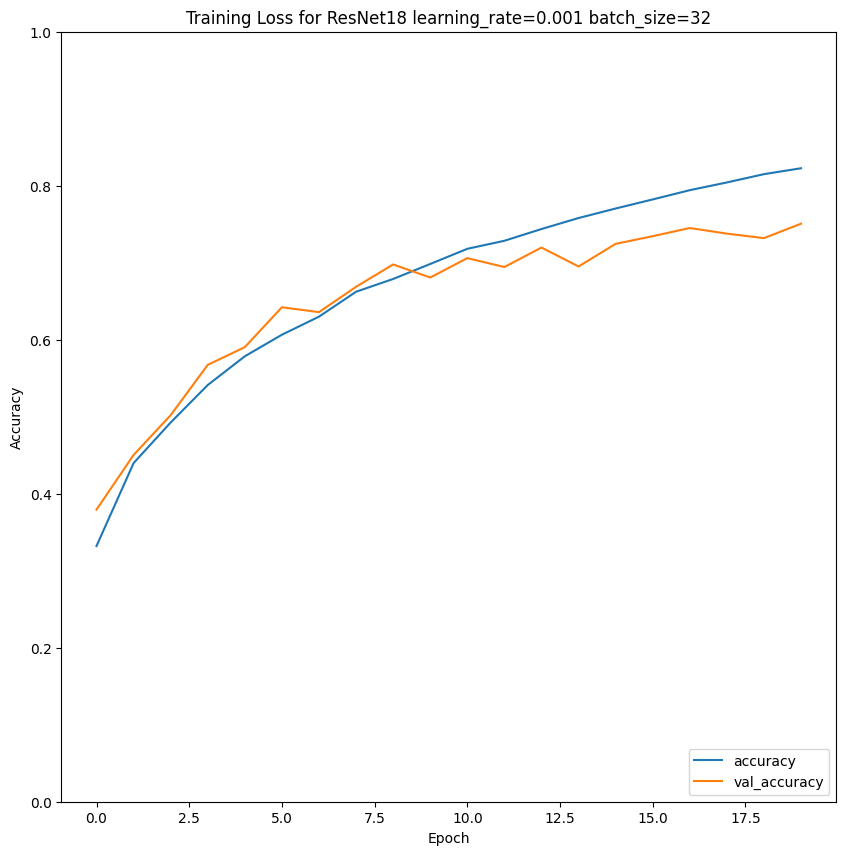

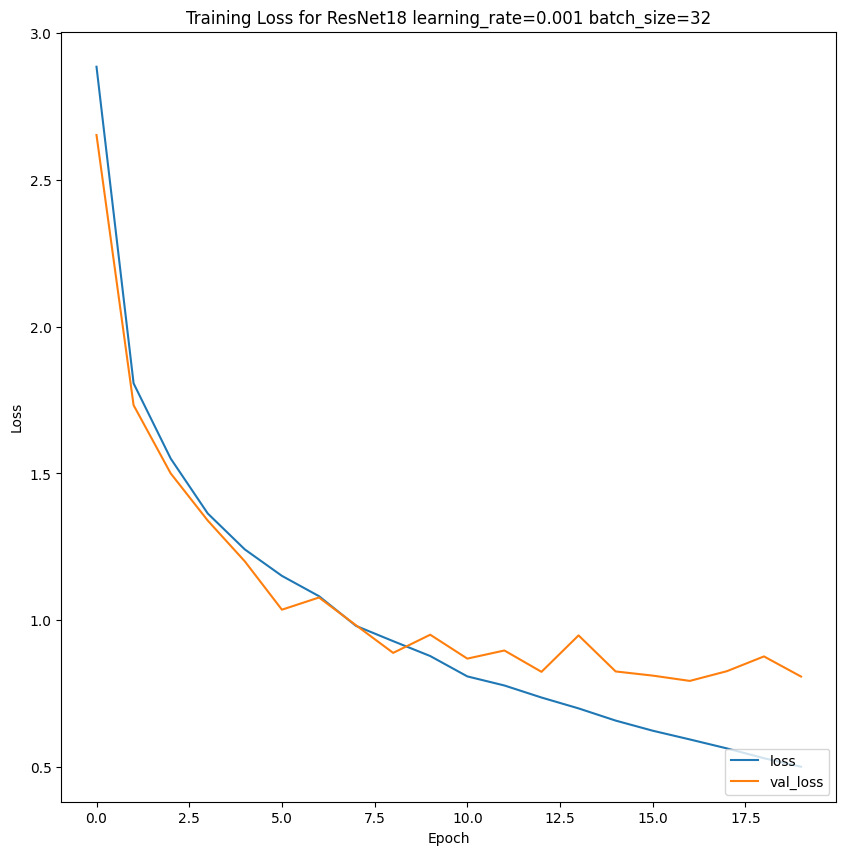

313/313 - 15s - 48ms/step - accuracy: 0.7421 - loss: 0.8549
Test accuracy: 0.7421000003814697
Test loss: 0.8548648357391357


2024-11-09 15:57:09.006707: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911
2024-11-09 15:57:09.006796: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773


In [54]:
run_resnet18(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

## Learning rate = 0.01

In [55]:
batch_size = 32
train_generator = data_generator(
    training_data["data"], training_data["labels"], image_size, image_size, batch_size=batch_size
)
validation_generator = data_generator(
    validation_data["data"],
    validation_data["labels"],
    image_size,
    image_size,
    batch_size=batch_size,
)
# Fit the model using the generator
steps_per_epoch = len(training_data["data"]) // batch_size
validation_steps = len(validation_data["data"]) // batch_size # Because of https://developers.google.com/machine-learning/glossary/#epoch
num_epochs = 15
learning_rate = 0.01

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 123s 71ms/step - accuracy: 0.1593 - loss: 2.4835 - val_accuracy: 0.1008 - val_loss: 1046.2598
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.1550 - loss: 2.2226 - val_accuracy: 0.0955 - val_loss: 397.4805
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.1484 - loss: 2.2550 - val_accuracy: 0.1016 - val_loss: 27.7741
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.1510 - loss: 2.2406 - val_accuracy: 0.1070 - val_loss: 13.0172
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.1585 - loss: 2.2338 - val_accuracy: 0.1059 - val_loss: 37.3750
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.1458 - loss: 2.2627 - val_accuracy: 0.1296 - val_loss: 9.0426
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 68ms/step - accuracy: 0.1623 - loss: 2.2282 - val_accuracy: 0.0664 - val_loss: 16.2964
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy

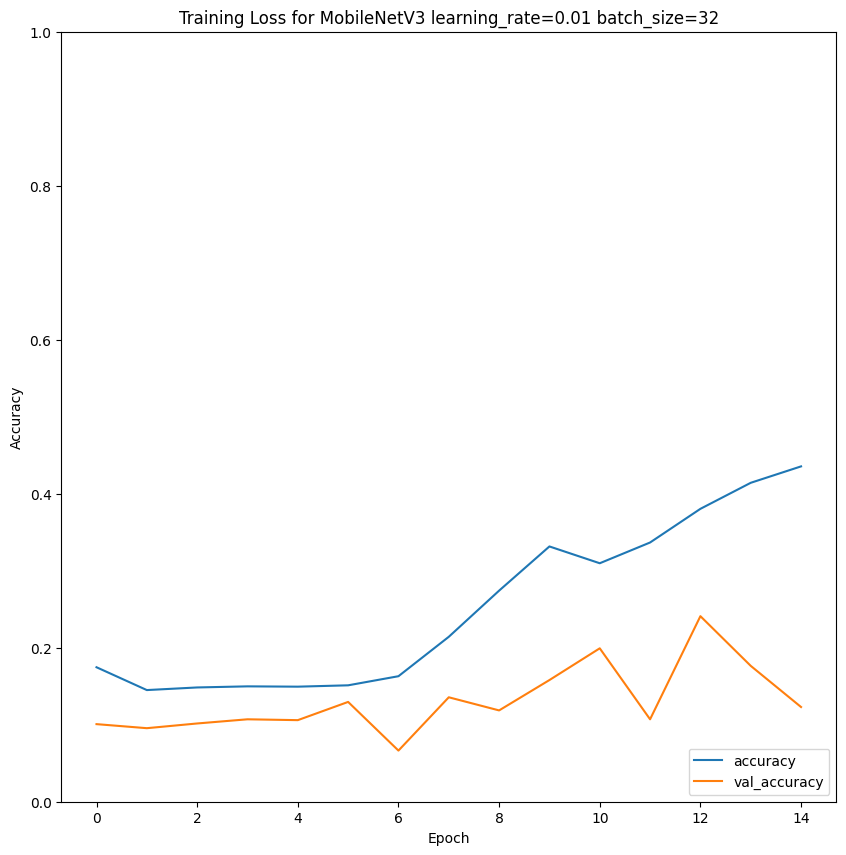

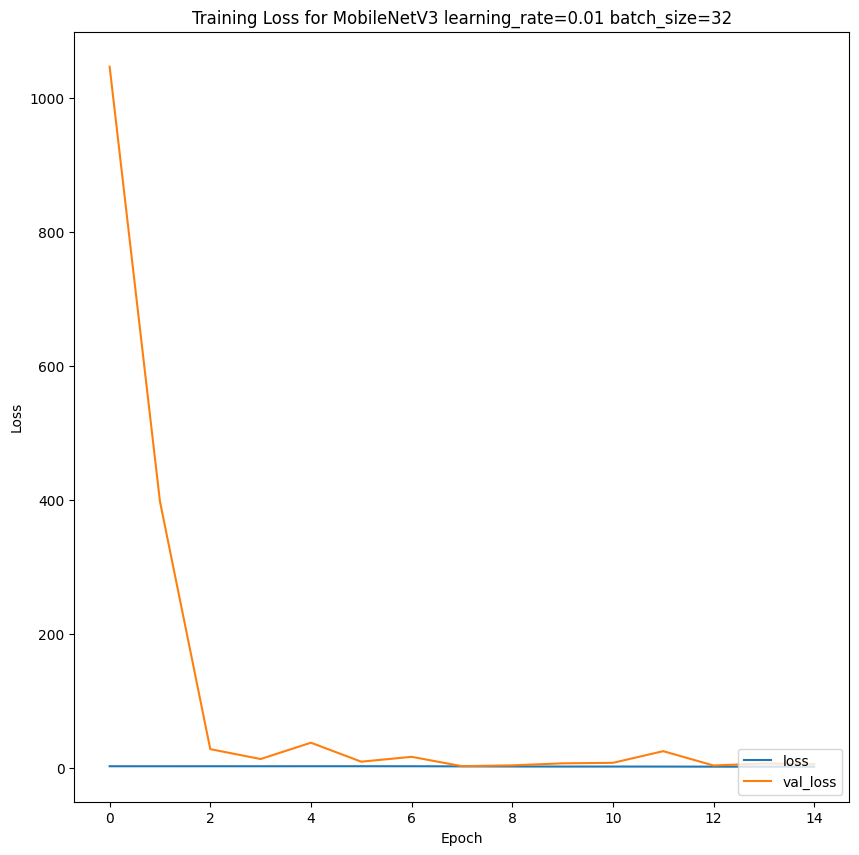

313/313 - 17s - 54ms/step - accuracy: 0.1217 - loss: 5.3780
Test accuracy: 0.1216999962925911
Test loss: 5.377993583679199


2024-11-09 16:18:45.961499: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 16:18:45.961709: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [56]:
run_mobilenetv3(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

/mnt/c/Users/chris/dev/repos/COMP-SCI-7318-Deep-Learning-Fundametals/Assignment2/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/mnt/c/Users/chris/dev/repos/COMP-SCI-7318-Deep-Learning-Fundametals/Assignment2/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 71ms/step - accuracy: 0.1468 - loss: 6.4369 - val_accuracy: 0.1959 - val_loss: 2.0694
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.1710 - loss: 2.1329 - val_accuracy: 0.1814 - val_loss: 2.1857
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 73ms/step - accuracy: 0.1622 - loss: 2.1671 - val_accuracy: 0.2064 - val_loss: 2.0575
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 69ms/step - accuracy: 0.1763 - loss: 2.1339 - val_accuracy: 0.2196 - val_loss: 2.0021
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.1753 - loss: 2.1279 - val_accuracy: 0.2029 - val_loss: 2.2368
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.1809 - loss: 2.1406 - val_accuracy: 0.2172 - val_loss: 2.0127
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 68ms/step - accuracy: 0.1846 - loss: 2.1052 - val_accuracy: 0.1916 - val_loss: 2.0842
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.1798 -

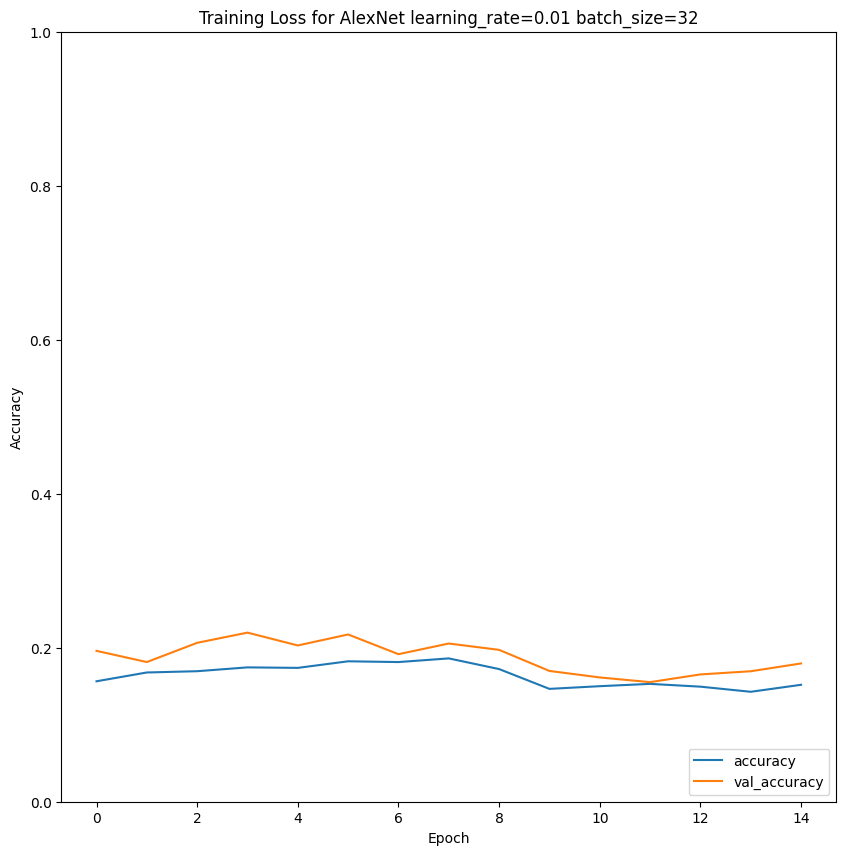

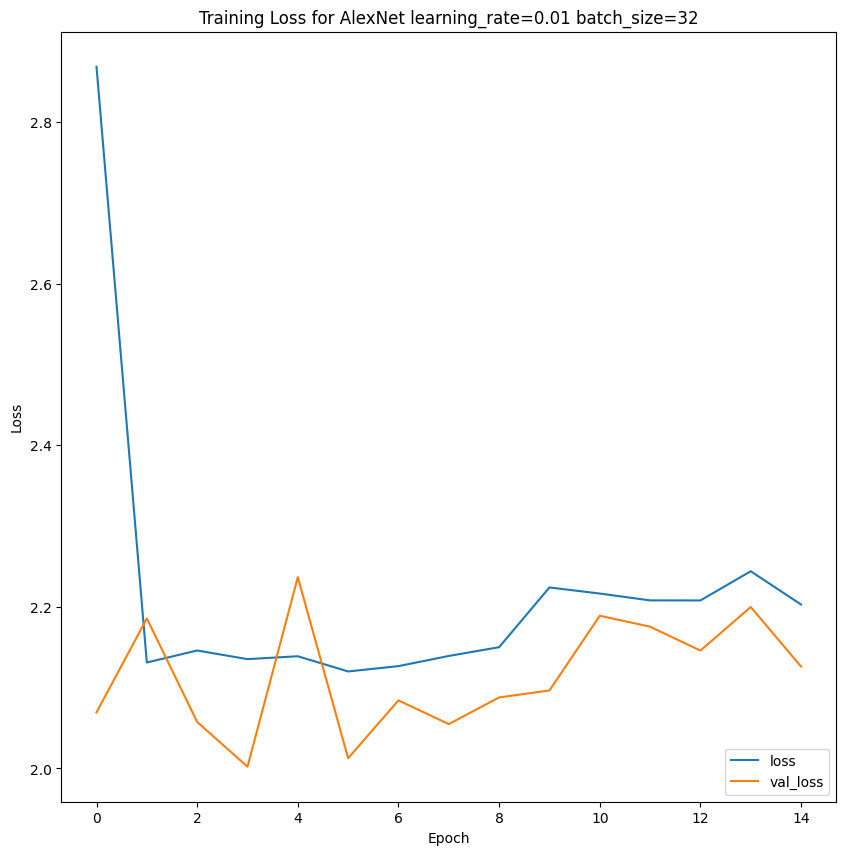

313/313 - 16s - 52ms/step - accuracy: 0.1753 - loss: 2.1235
Test accuracy: 0.1753000020980835
Test loss: 2.1235053539276123


2024-11-09 16:40:30.076655: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911
2024-11-09 16:40:30.076722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773


In [57]:
run_alexnet(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 69ms/step - accuracy: 0.2153 - loss: 33.0387 - val_accuracy: 0.3344 - val_loss: 2.5342
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.3529 - loss: 2.0976 - val_accuracy: 0.3758 - val_loss: 1.8829
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.3951 - loss: 1.7050 - val_accuracy: 0.4515 - val_loss: 1.5598
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.4027 - loss: 1.6537 - val_accuracy: 0.4231 - val_loss: 1.5920
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.4038 - loss: 1.6523 - val_accuracy: 0.3991 - val_loss: 1.6296
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.3934 - loss: 1.6640 - val_accuracy: 0.3643 - val_loss: 1.8008
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.3919 - loss: 1.6715 - val_accuracy: 0.4087 - val_loss: 1.6254
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.3945 

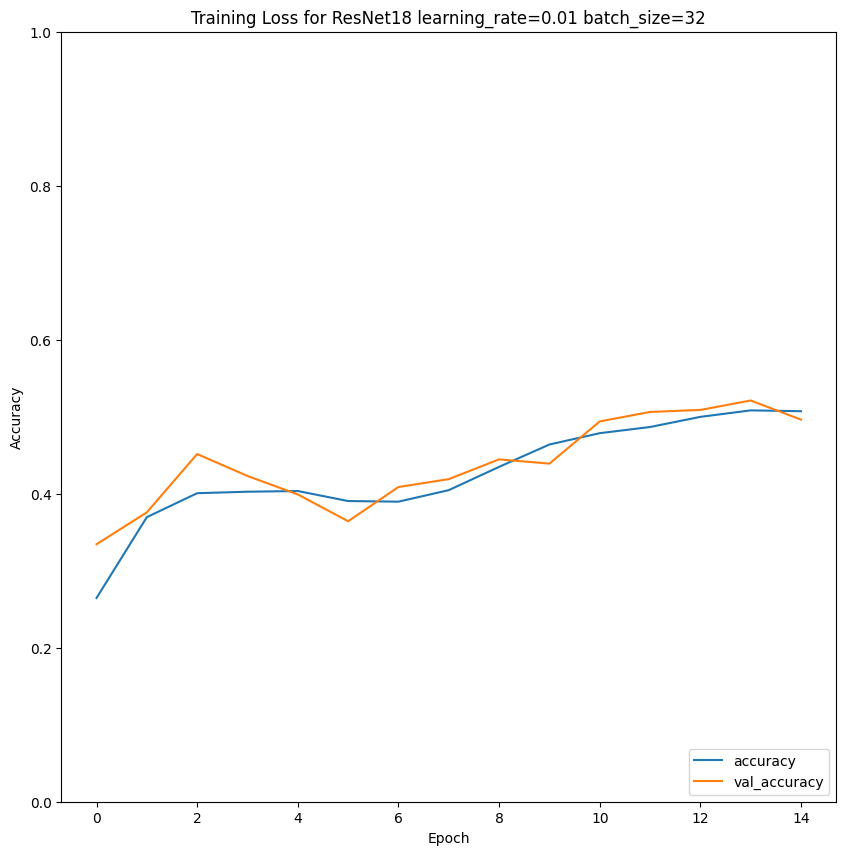

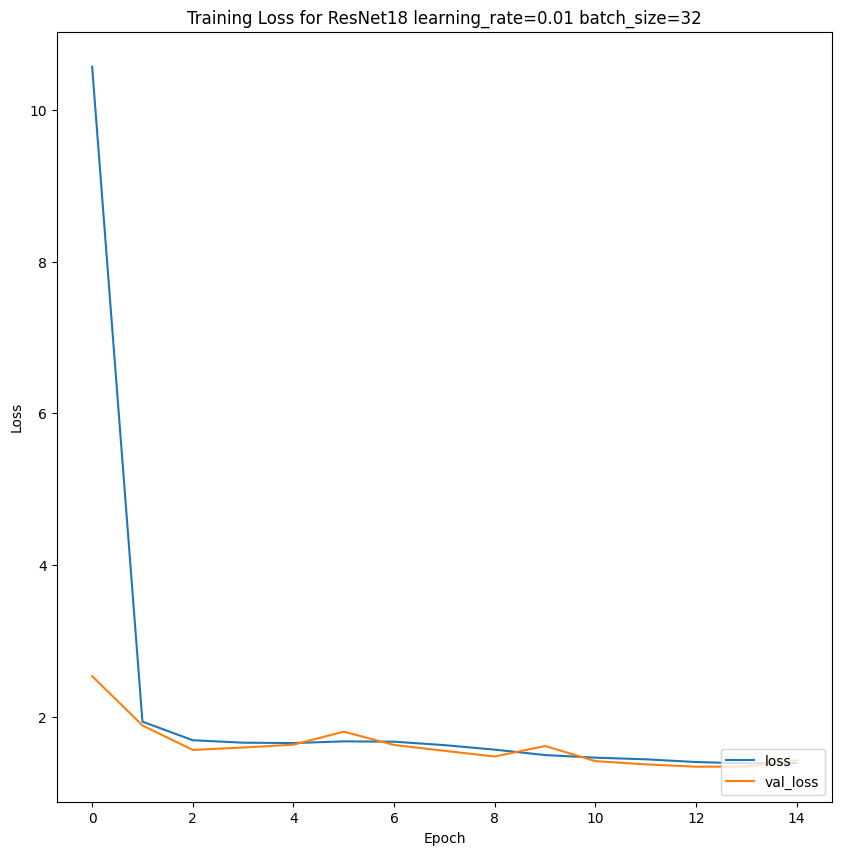

313/313 - 15s - 48ms/step - accuracy: 0.4849 - loss: 1.4289
Test accuracy: 0.48489999771118164
Test loss: 1.4288570880889893


2024-11-09 17:00:56.595987: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 17:00:56.596060: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [58]:
run_resnet18(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

## Learning rate = 0.1

In [59]:
batch_size = 32
train_generator = data_generator(
    training_data["data"], training_data["labels"], image_size, image_size, batch_size=batch_size
)
validation_generator = data_generator(
    validation_data["data"],
    validation_data["labels"],
    image_size,
    image_size,
    batch_size=batch_size,
)
# Fit the model using the generator
steps_per_epoch = len(training_data["data"]) // batch_size
validation_steps = len(validation_data["data"]) // batch_size # Because of https://developers.google.com/machine-learning/glossary/#epoch
num_epochs = 10
learning_rate = 0.1

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 116s 70ms/step - accuracy: 0.1147 - loss: 3.4964 - val_accuracy: 0.0953 - val_loss: 2125079.0000
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.1038 - loss: 4.4059 - val_accuracy: 0.0977 - val_loss: 92421980160.0000
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.1116 - loss: 3.2740 - val_accuracy: 0.0977 - val_loss: 71755.5703
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.1137 - loss: 3.1429 - val_accuracy: 0.0944 - val_loss: 4550.4590
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.1142 - loss: 2.7912 - val_accuracy: 0.1040 - val_loss: 3.4775
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.1378 - loss: 3.1336 - val_accuracy: 0.0952 - val_loss: 58030.5664
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.1264 - loss: 2.7986 - val_accuracy: 0.0975 - val_loss: 2487.1521
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s

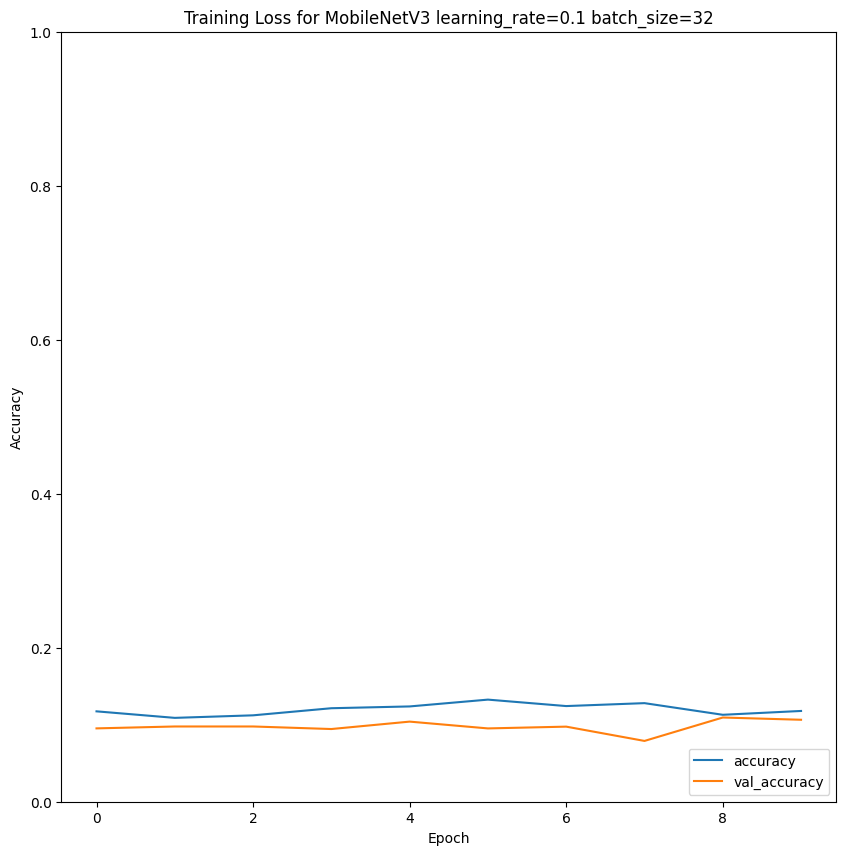

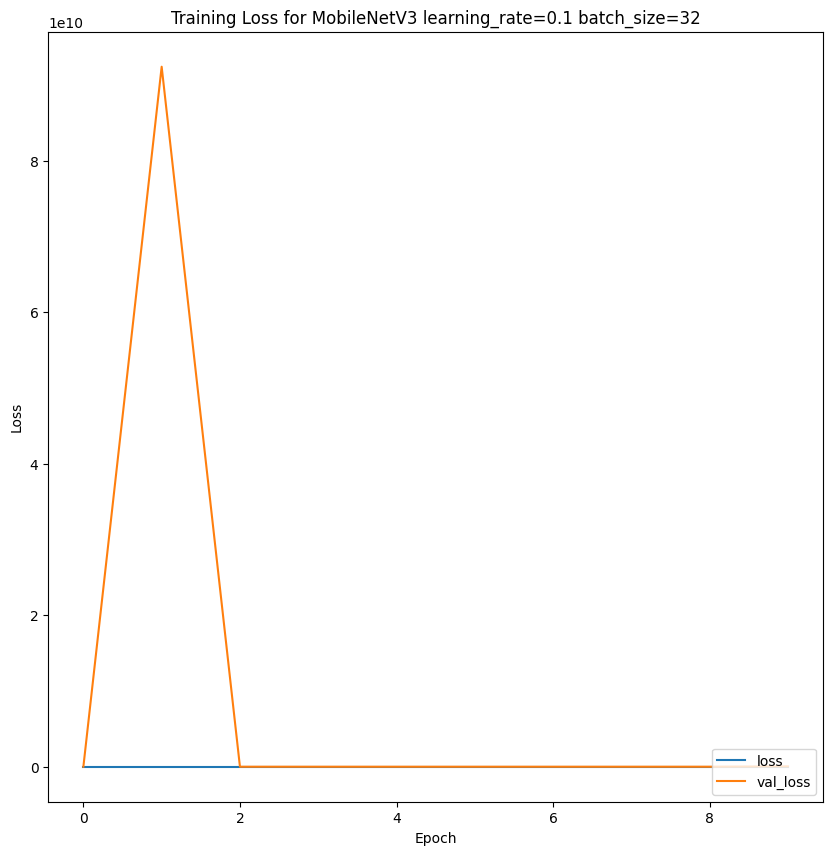

313/313 - 16s - 52ms/step - accuracy: 0.1037 - loss: 44851972.0000
Test accuracy: 0.10369999706745148
Test loss: 44851972.0


2024-11-09 17:15:15.205803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 17:15:15.205865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [60]:
run_mobilenetv3(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 70ms/step - accuracy: 0.1033 - loss: 1505.0258 - val_accuracy: 0.1004 - val_loss: 2.3264
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.0983 - loss: 3.5343 - val_accuracy: 0.0981 - val_loss: 2.3201
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.1026 - loss: 3.7539 - val_accuracy: 0.1000 - val_loss: 2.3183
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.0965 - loss: 2.3153 - val_accuracy: 0.0978 - val_loss: 2.3160
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 69ms/step - accuracy: 0.0996 - loss: 2.3301 - val_accuracy: 0.1015 - val_loss: 2.3126
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.0997 - loss: 2.3142 - val_accuracy: 0.1018 - val_loss: 2.3124
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.1019 - loss: 44.3236 - val_accuracy: 0.1016 - val_loss: 2.3180
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s 62ms/step - accuracy: 0.09

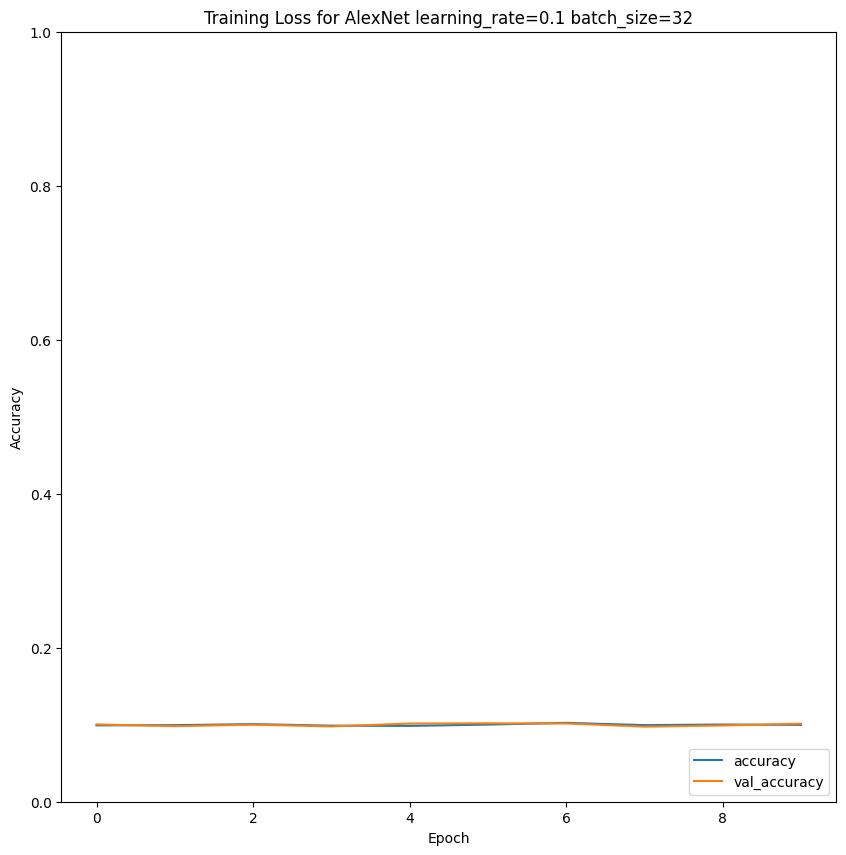

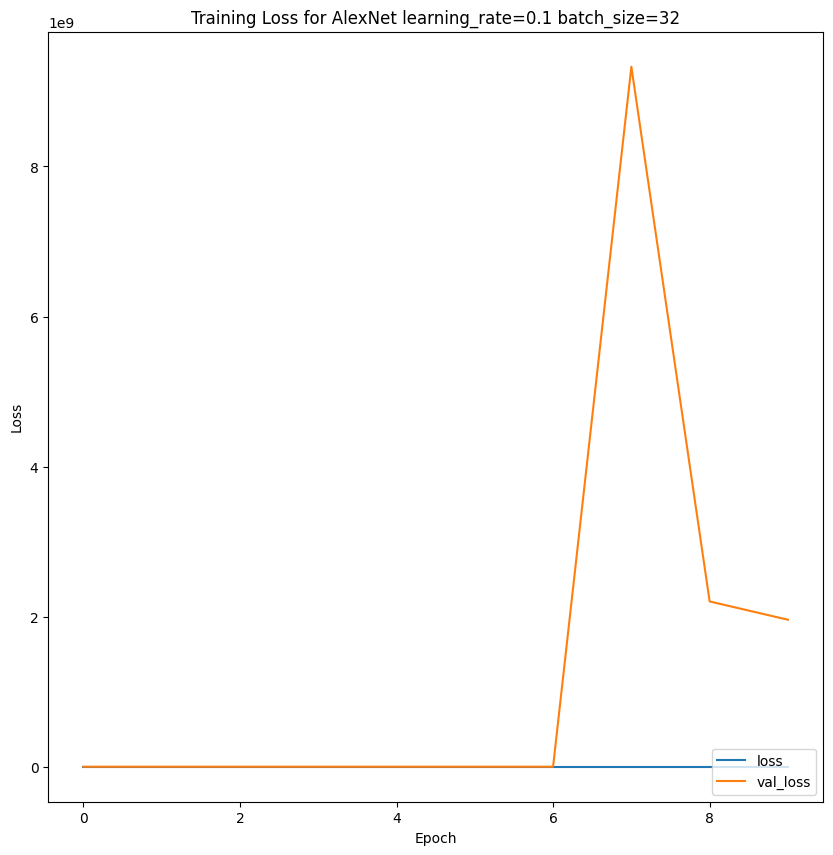

313/313 - 16s - 51ms/step - accuracy: 0.0999 - loss: 3243719680.0000
Test accuracy: 0.09989999979734421
Test loss: 3243719680.0


2024-11-09 17:29:44.533815: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 17:29:44.533879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [61]:
run_alexnet(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 69ms/step - accuracy: 0.1238 - loss: 2097478.2500 - val_accuracy: 0.0858 - val_loss: 733.1736
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.1336 - loss: 537.1328 - val_accuracy: 0.1417 - val_loss: 409.8237
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.1425 - loss: 388.0870 - val_accuracy: 0.1968 - val_loss: 321.6912
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.1442 - loss: 3111.8623 - val_accuracy: 0.1970 - val_loss: 295.0379
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.1697 - loss: 282.1204 - val_accuracy: 0.1712 - val_loss: 234.3414
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.1798 - loss: 197.5588 - val_accuracy: 0.1619 - val_loss: 176.9774
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.1786 - loss: 182.4540 - val_accuracy: 0.1892 - val_loss: 122.1461
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7

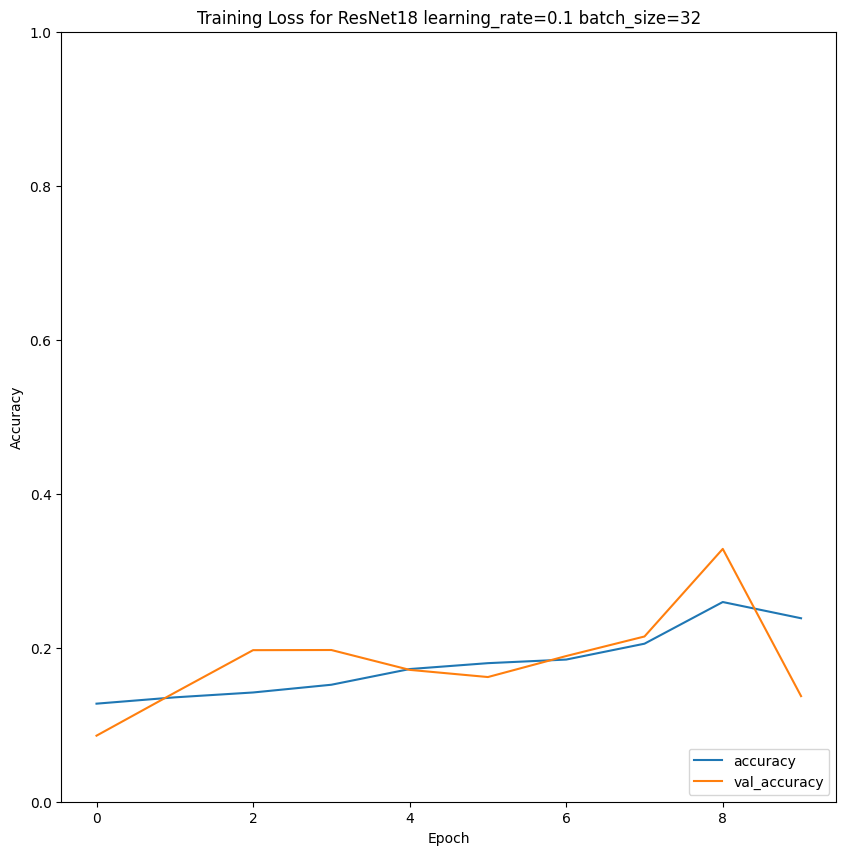

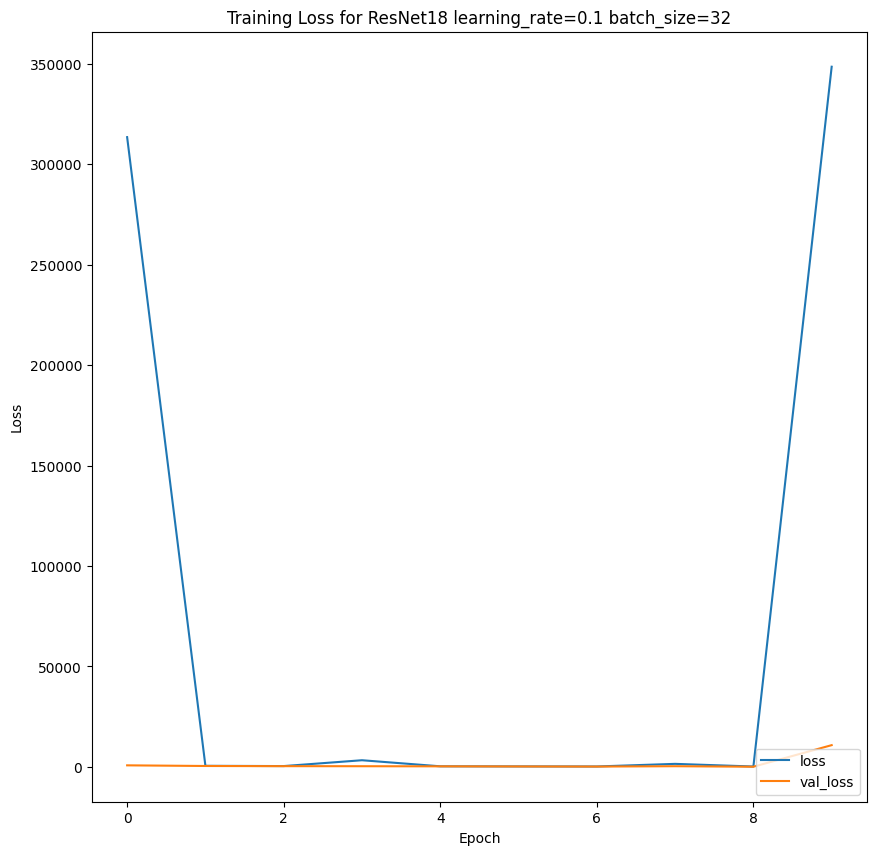

313/313 - 15s - 47ms/step - accuracy: 0.1408 - loss: 10647.1836
Test accuracy: 0.14079999923706055
Test loss: 10647.18359375


2024-11-09 17:43:46.965678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5603099421714065773
2024-11-09 17:43:46.965737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3192657618115604911


In [62]:
run_resnet18(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    train_generator=train_generator,
    validation_generator=validation_generator,
    validation_steps=validation_steps,
)

In [64]:
import tensorflow as tf

import keras
from keras import layers


class ConvolutionBlock2(tf.keras.Model):
    """
    This class will create a convolution block for the resnet model
    by subclassing Model class
    """

    def __init__(self, filters, kernel_size):
        super(ConvolutionBlock2, self).__init__(name="")

        self.conv1 = layers.Conv2D(filters, kernel_size, padding="same")
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(filters, kernel_size, padding="same")
        self.bn2 = layers.BatchNormalization()

        self.act = layers.Activation("relu")
        self.add = layers.Add()

    def call(self, input_tensor):
        # Block 1: Conv--> BN--> ReLU
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        # Block 2: Conv--> BN--> ReLU
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        # skip connection
        x = self.add([x, input_tensor])
        x = self.act(x)
        return x


class IdentityBlock2(tf.keras.Model):
    """
    This class will create an identity block for the resnet model
    by subclassing Model class
    """

    def __init__(self, filters, kernel_size):
        super(IdentityBlock2, self).__init__(name="")

        self.conv1 = layers.Conv2D(filters, kernel_size, padding="same")
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(filters, kernel_size, padding="same")
        self.bn2 = layers.BatchNormalization()

        self.act = layers.Activation("relu")
        self.add = layers.Add()

    def call(self, input_tensor):
        # Block 1: Conv--> BN--> ReLU
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        # Block 2: Conv--> BN--> ReLU
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        # skip connection
        x = self.add([x, input_tensor])
        x = self.act(x)
        return x


class ResNet182(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet182, self).__init__()
        self.conv = layers.Conv2D(64, 7, padding="same")
        self.bn = layers.BatchNormalization()
        self.act = layers.Activation("relu")
        self.max_pool = layers.MaxPool2D((3, 3))

        # create Identity blocks
        self.conv1 = ConvolutionBlock2(64, 3)
        self.id1 = IdentityBlock2(64, 3)
        self.conv2 = ConvolutionBlock2(128, 3)
        self.id2 = IdentityBlock2(128, 3)
        self.conv3 = ConvolutionBlock2(256, 3)
        self.id3 = IdentityBlock2(256, 3)
        self.conv4 = ConvolutionBlock2(512, 3)
        self.id4 = IdentityBlock2(512, 3)

        self.global_pool = layers.GlobalAveragePooling2D()
        self.classifier = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # call identity blocks
        x = self.conv1(x)
        x = self.id1(x)
        x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
        x = self.conv2(x)
        x = self.id2(x)
        x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
        x = self.conv3(x)
        x = self.id3(x)
        x = layers.Conv2D(512, 3, strides=2, padding='same')(x)
        x = self.conv4(x)
        x = self.id4(x)

        x = self.global_pool(x)
        return self.classifier(x)


def compile_resnet_model2(num_classes, learning_rate):
    resnet18 = ResNet182(num_classes)

    resnet18.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    return resnet18

resnet_model2 = compile_resnet_model2(num_classes, learning_rate)

model = resnet_model2
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

plt.figure(figsize=(10, 10))
plt.title(f'Training Loss for ResNet18 -2 learning_rate={learning_rate} batch_size={batch_size}')
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(10, 10))
plt.title(f'Training Loss for ResNet18 -2 learning_rate={learning_rate} batch_size={batch_size}')
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower right")
plt.show()

test_generator = test_data_generator(
    test_data["data"], test_data["labels"], image_size, image_size, batch_size=batch_size
)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

Epoch 1/10


ValueError: Exception encountered when calling ResNet182.call().

[1mtf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.[0m

Arguments received by ResNet182.call():
  • inputs=tf.Tensor(shape=(None, 32, 32, 3), dtype=float32)